In [563]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import time
from sklearn.cluster import KMeans


from sklearn.metrics import silhouette_score


%matplotlib inline

n_samples = 1500
random_state = 170
transformation = [[1,-1],[-1,2]]


x,y = make_blobs(n_samples=n_samples, random_state=random_state)
xani = np.dot(x, transformation)


In [553]:
x

array([[-5.19811282e+00,  6.41869316e-01],
       [-5.75229538e+00,  4.18627111e-01],
       [-1.08448984e+01, -7.55352273e+00],
       ...,
       [ 1.36105255e+00, -9.07491863e-01],
       [-3.54141108e-01,  7.12241630e-01],
       [ 1.88577252e+00,  1.41185693e-03]])

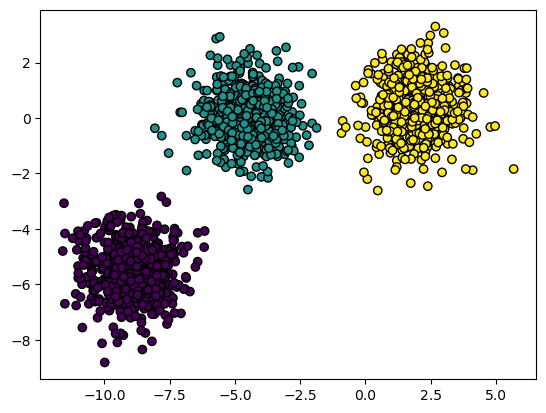

In [555]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', edgecolors='k')

In [501]:
y

array([1, 1, 0, ..., 2, 2, 2])

In [503]:
xani[0:5,0:5]

array([[-5.83998214,  6.48185145],
       [-6.17092249,  6.5895496 ],
       [-3.29137565, -4.26214708],
       [-3.76996743,  2.96895002],
       [-3.55850705,  3.59785195]])

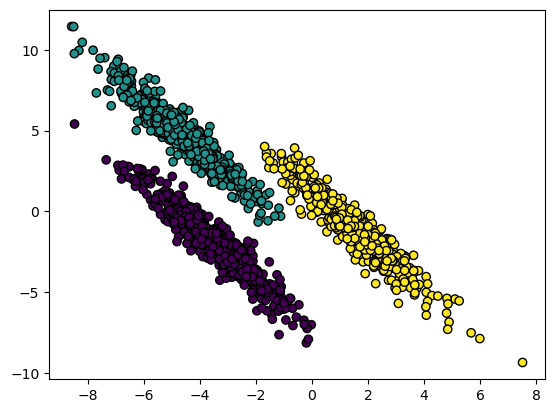

In [505]:
plt.scatter(xani[:, 0], xani[:, 1], c=y, cmap='viridis', edgecolors='k')

J = $\sum^{N}_{n=1}\sum^{K}_{k=1}r(nk)|| x_n - Uk||^2_2$

# K is the number of class
# r(nk) shows if xn is in class k.

In [507]:
def dists(x,cs):
    return np.linalg.norm(x[:,np.newaxis,:]-cs,axis=2)
    
def init(x,k):
    idx=np.random.choice(x.shape[0],k,replace=False)
    return x[idx]

def new_cents(x, labels, k):
    return np.array([x[labels==i].mean(axis=0) if np.any(labels==i)
                     else x[np.random.choice(x.shape[0])] for i in range(k)])

def wcss(x, labels, centroids):
    return sum(np.sum((x[labels == i] - centroids[i])**2) for i in range(len(centroids)))

def kmeans(x, k, max_iters=300, tol=1e-4):
    cents = init(x, k)
    objective_values = []
    
    for _ in range(max_iters):
        ds = dists(x, cents)
        labels = np.argmin(ds, axis=1)
        new_cs = new_cents(x, labels, k)
        
        objective_value = np.sum(np.min(ds, axis=1) ** 2)
        objective_values.append(objective_value)
        
        if np.linalg.norm(new_cs - cents) < tol:
            break
        cents = new_cs
    
    return labels, cents, objective_values


def plot_clusters(x,labels,cents,title):
    plt.scatter(x[:,0],x[:,1],c=labels)
    plt.scatter(cents[:,0],cents[:,1], c='red', marker='x',s=200)
    plt.title(title)
    plt.show()




In [509]:
start_time=time.time()
ls_iso,cents_iso,obj_vals_iso=kmeans(x, 3)
ls_ani,cents_ani,obj_vals_ani=kmeans(xani, 3)
end_time = time.time()
kmeans_t=end_time - start_time

In [511]:
start_time = time.time()
sk_kmeans_iso=KMeans(n_clusters=3, random_state=42, n_init=10).fit(x)
sk_kmeans_ani=KMeans(n_clusters=3, random_state=42, n_init=10).fit(xani)
end_time = time.time()
sklearn_t=end_time - start_time

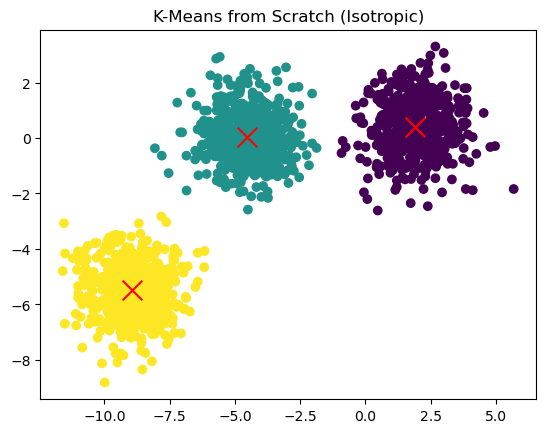

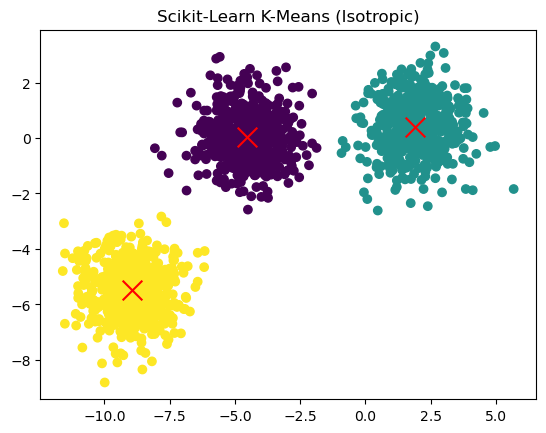

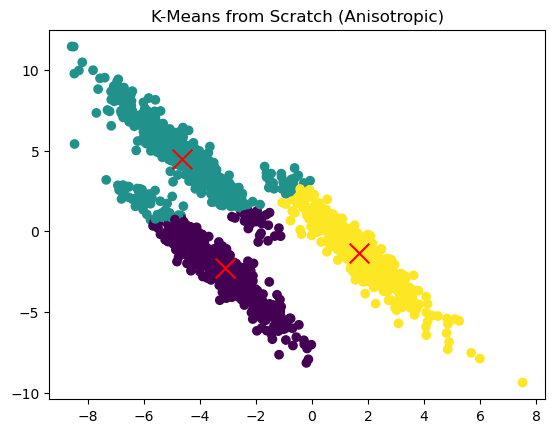

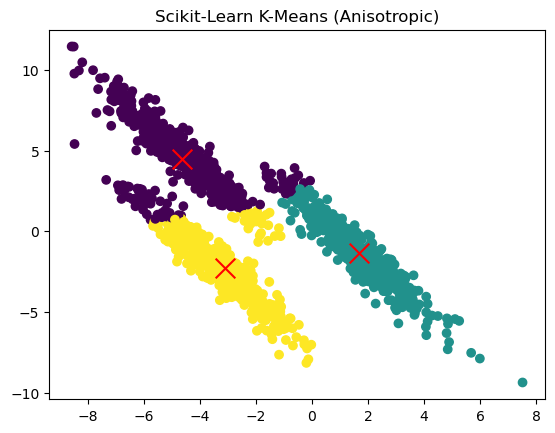

In [513]:
plot_clusters(x,ls_iso,cents_iso, "K-Means from Scratch (Isotropic)")
plot_clusters(x, sk_kmeans_iso.labels_, sk_kmeans_iso.cluster_centers_, "Scikit-Learn K-Means (Isotropic)")
plot_clusters(xani,ls_ani,cents_ani, "K-Means from Scratch (Anisotropic)")
plot_clusters(xani, sk_kmeans_ani.labels_, sk_kmeans_ani.cluster_centers_, "Scikit-Learn K-Means (Anisotropic)")

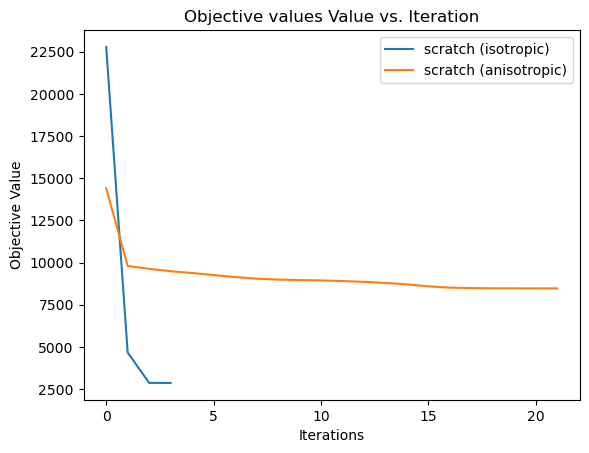

In [515]:
plt.plot(obj_vals_iso, label='scratch (isotropic)')
plt.plot(obj_vals_ani, label='scratch (anisotropic)')
plt.title("Objective values Value vs. Iteration")
plt.xlabel("Iterations")
plt.ylabel("Objective Value")
plt.legend()
plt.show()

In [447]:
print(f"execution time: k means from scratch = {kmeans_t:.4f}s, sklearn = {sklearn_t:.4f}s")

execution time: k means from scratch = 0.0141s, sklearn = 0.0908s


In [449]:
print("final objective value")
print(f"scratch isotropic: {obj_vals_iso[-1]:.4f}")
print(f"scikit-learn isotropic: {sk_kmeans_iso.inertia_:.4f}")
print(f"scratch anisotropic: {obj_vals_ani[-1]:.4f}")
print(f"scikit-learn anisotropic: {sk_kmeans_ani.inertia_:.4f}")

final objective value
scratch isotropic: 2862.7319
scikit-learn isotropic: 2862.7319
scratch anisotropic: 8467.6991
scikit-learn anisotropic: 8467.6991


In [557]:
def kmeans_plus_plus(x, k):
    n_samples, _ = x.shape
    centroids = []
    
    centroids.append(x[np.random.choice(n_samples)])
    
    for _ in range(1, k):
        distances = np.min(cdist(x, np.array(centroids)), axis=1)
        probabilities = distances ** 2
        probabilities /= probabilities.sum()  # Normalize probabilities
        
        next_centroid = x[np.random.choice(n_samples, p=probabilities)]
        centroids.append(next_centroid)
    
    return np.array(centroids)

def percentile_based_init(x, k):
    percentiles = np.linspace(100 / (k + 1), 100 * k / (k + 1), k - 1)
    grid = []
    
    for p1 in percentiles:
        x_percentile = np.percentile(x[:, 0], p1)
        for p2 in percentiles:
            y_percentile = np.percentile(x[:, 1], p2)
            grid.append((x_percentile, y_percentile))
    
    grid = np.array(grid)
    sigma = np.mean(cdist(x, x))
    densities = np.array([np.sum(np.exp(-np.sum((X - g) ** 2, axis=1) / (2 * sigma ** 2))) for g in grid])
    
    top_indices = np.argsort(densities)[-k:]
    return grid[top_indices]

def generate_synthetic_data():
    np.random.seed(42)
    cluster1 = np.random.randn(50, 2) + np.array([2, 2])
    cluster2 = np.random.randn(50, 2) + np.array([-2, -2])
    cluster3 = np.random.randn(50, 2) + np.array([5, -3])
    return np.vstack((cluster1, cluster2, cluster3))


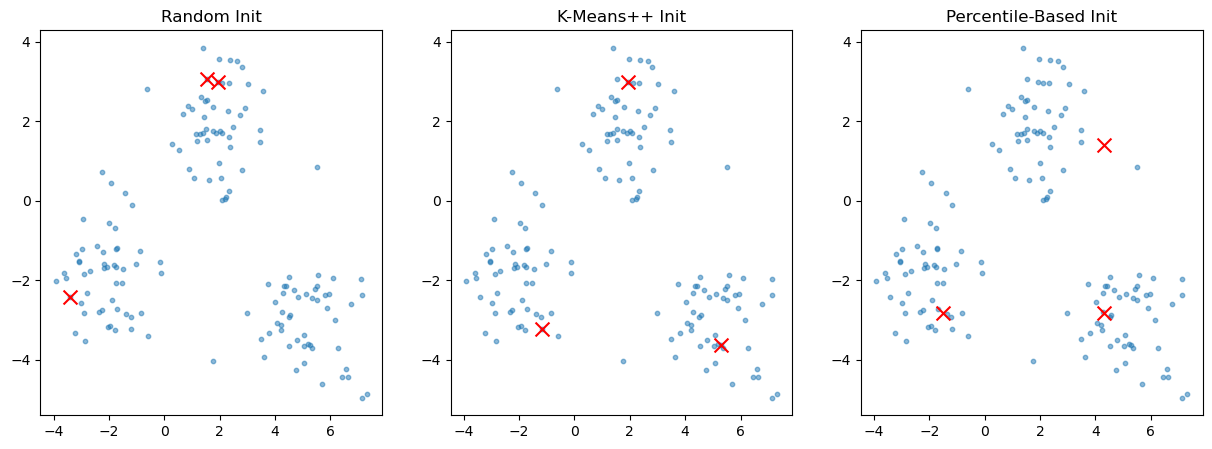

In [559]:

x = generate_synthetic_data()
k = 3

random_init = x[np.random.choice(x.shape[0], k, replace=False)]
kmeanspp_init = kmeans_plus_plus(x, k)
percentile_init = percentile_based_init(x, k)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, centroids, title in zip(axs, [random_init, kmeanspp_init, percentile_init],
                                ['Random Init', 'K-Means++ Init', 'Percentile-Based Init']):
    ax.scatter(x[:, 0], x[:, 1], s=10, alpha=0.5)
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=100)
    ax.set_title(title)
plt.show()


In [585]:
def kmeans_l1(x, k, max_iters=100, tol=1e-4):
    centroids = x[np.random.choice(x.shape[0], k, replace=False)]
    objective_values = []
    for _ in range(max_iters):
        distances = np.sum(np.abs(x[:, np.newaxis, :] - centroids), axis=2)
        labels = np.argmin(distances, axis=1)  # Ensure labels are the correct shape
        
        new_centroids = np.array([
            np.median(x[labels == i], axis=0) if np.any(labels == i) else x[np.random.choice(x.shape[0])]
            for i in range(k)
        ])
        objective_value = np.sum(np.min(distances, axis=1) ** 2)
        objective_values.append(objective_value)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
        
    return labels, centroids,objective_values



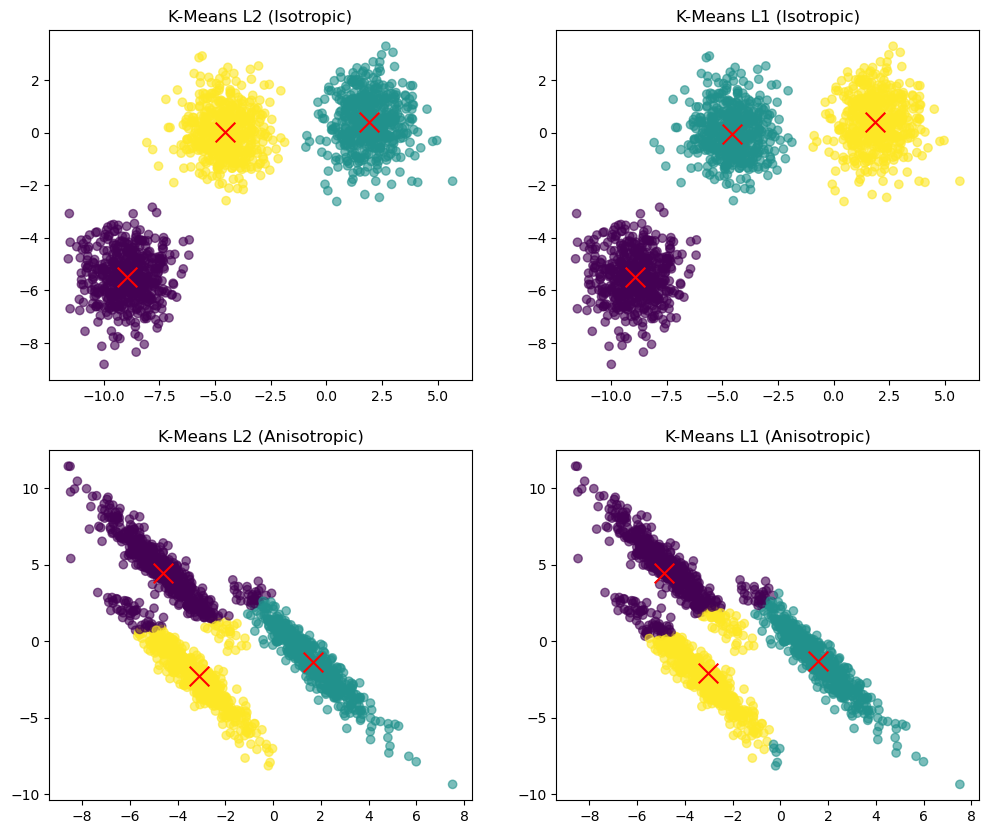

In [595]:
labels_l1_iso, cents_l1_iso,obj_vals_iso1= kmeans_l1(x, k=3)
labels_l1_ani, cents_l1_ani,obj_vals_ani1= kmeans_l1(xani, k=3)


labels_l2_iso, cents_l2_iso, _ = kmeans(x, k=3)
labels_l2_ani, cents_l2_ani, _ = kmeans(xani, k=3)


fig, ax = plt.subplots(2, 2, figsize=(12, 10))


ax[0, 0].scatter(x[:, 0], x[:, 1], c=labels_l2_iso, cmap='viridis', alpha=0.6)
ax[0, 0].scatter(cents_l2_iso[:, 0], cents_l2_iso[:, 1], c='red', marker='x', s=200)
ax[0, 0].set_title("K-Means L2 (Isotropic)")


ax[0, 1].scatter(x[:, 0], x[:, 1], c=labels_l1_iso, cmap='viridis', alpha=0.6)
ax[0, 1].scatter(cents_l1_iso[:, 0], cents_l1_iso[:, 1], c='red', marker='x', s=200)
ax[0, 1].set_title("K-Means L1 (Isotropic)")


ax[1, 0].scatter(xani[:, 0], xani[:, 1], c=labels_l2_ani, cmap='viridis', alpha=0.6)
ax[1, 0].scatter(cents_l2_ani[:, 0], cents_l2_ani[:, 1], c='red', marker='x', s=200)
ax[1, 0].set_title("K-Means L2 (Anisotropic)")


ax[1, 1].scatter(xani[:, 0], xani[:, 1], c=labels_l1_ani, cmap='viridis', alpha=0.6)
ax[1, 1].scatter(cents_l1_ani[:, 0], cents_l1_ani[:, 1], c='red', marker='x', s=200)
ax[1, 1].set_title("K-Means L1 (Anisotropic)")

plt.show()


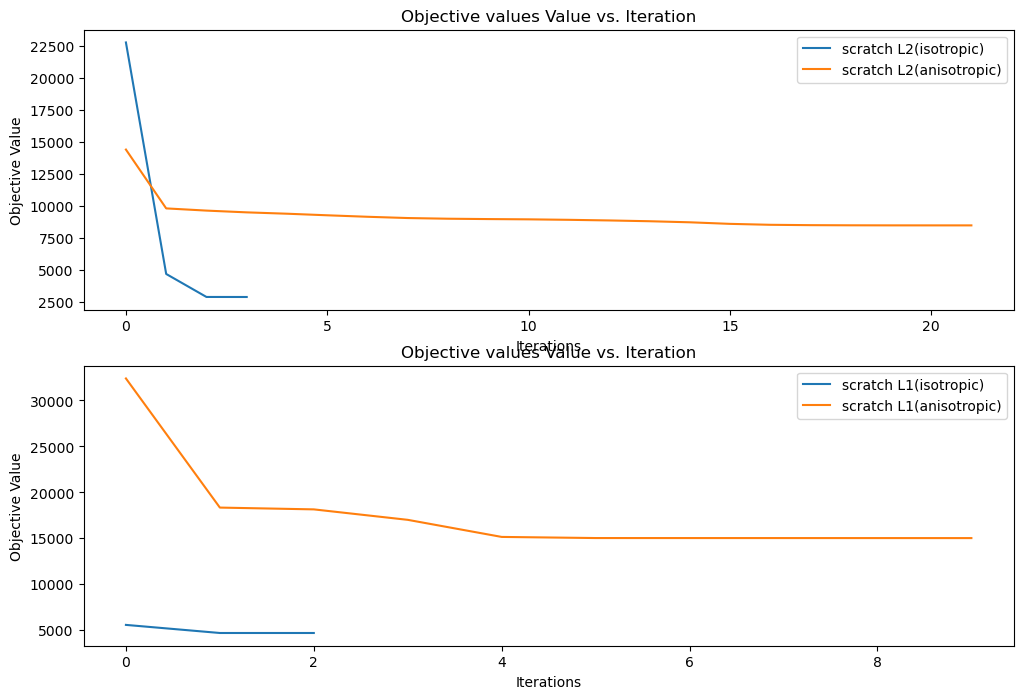

In [599]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(obj_vals_iso, label='scratch L2(isotropic)')
axes[0].plot(obj_vals_ani, label='scratch L2(anisotropic)')
axes[0].set_title("Objective values Value vs. Iteration")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("Objective Value")
axes[0].legend()

axes[1].plot(obj_vals_iso1, label='scratch L1(isotropic)')
axes[1].plot(obj_vals_ani1, label='scratch L1(anisotropic)')
axes[1].set_title("Objective values Value vs. Iteration")
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("Objective Value")
axes[1].legend()
plt.show()

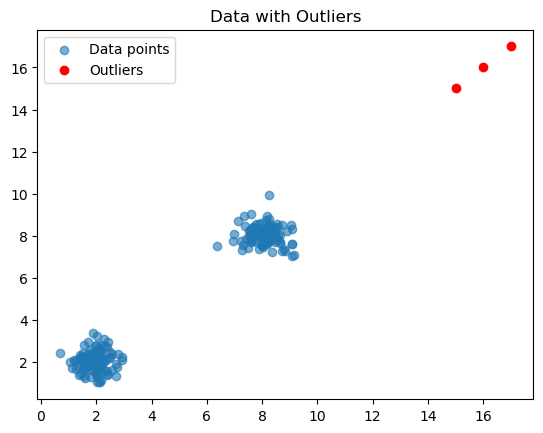

In [667]:
np.random.seed(42)
cluster_1 = np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2))
cluster_2 = np.random.normal(loc=[8, 8], scale=0.5, size=(100, 2))
X = np.vstack([cluster_1, cluster_2])


outliers = np.array([[15, 15], [16, 16], [17, 17]])
xoutliers = np.vstack([X, outliers])

plt.scatter(X[:, 0], X[:, 1], label='Data points', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:, 1], color='red', label='Outliers')
plt.title('Data with Outliers')
plt.legend()
plt.show()

In [669]:
labels_l1_outliers, centroids_l1_outliers, objective_values_l1_outliers = kmeans_l1(xoutliers, k=2)
labels_euclidean_outliers, centroids_euclidean_outliers, objective_values_euclidean_outliers = kmeans(xoutliers, k=2)

In [671]:
print("Centroids from kmeans_l1 (with outliers):", centroids_l1_outliers)
print("Centroids from kmeans (with outliers):", centroids_euclidean_outliers)

Centroids from kmeans_l1 (with outliers): [[8.09952985 8.01050192]
 [1.98236555 2.06616192]]
Centroids from kmeans (with outliers): [[1.94221787 2.01701116]
 [8.29526637 8.25412022]]


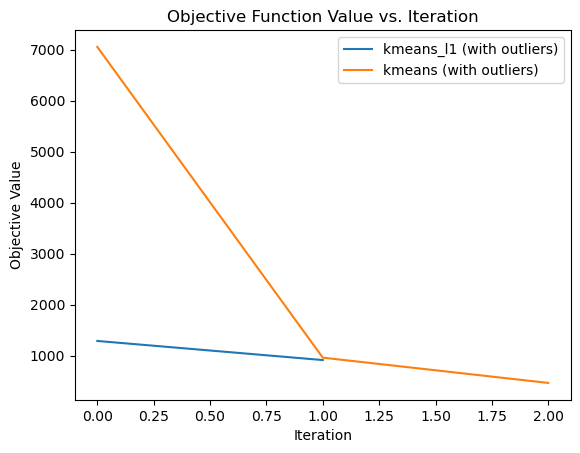

In [673]:
plt.plot(objective_values_l1_outliers, label="kmeans_l1 (with outliers)")
plt.plot(objective_values_euclidean_outliers, label="kmeans (with outliers)")
plt.title('Objective Function Value vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.legend()
plt.show()

In [675]:
from sklearn.metrics import silhouette_score
silhouette_l1_outliers = silhouette_score(xoutliers, labels_l1_outliers)
print(f'Silhouette Score for kmeans_l1 (with outliers): {silhouette_l1_outliers}')
silhouette_euclidean_outliers = silhouette_score(xoutliers, labels_euclidean_outliers)
print(f'Silhouette Score for kmeans (with outliers): {silhouette_euclidean_outliers}')

Silhouette Score for kmeans_l1 (with outliers): 0.8784788857319532
Silhouette Score for kmeans (with outliers): 0.8784788857319532


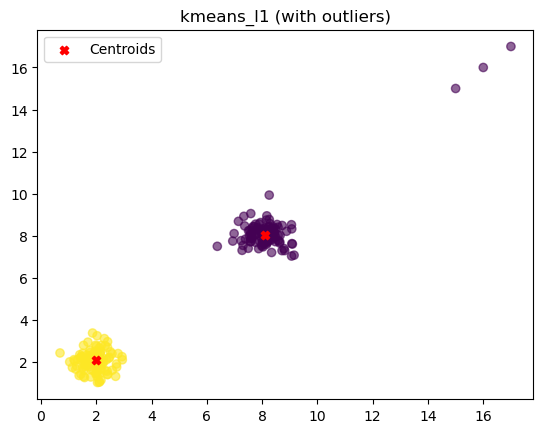

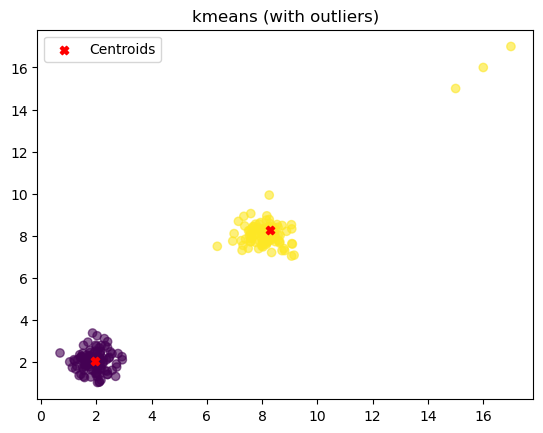

In [691]:
plt.scatter(xoutliers[:, 0], xoutliers[:, 1], c=labels_l1_outliers, cmap='viridis', alpha=0.6)
plt.scatter(centroids_l1_outliers[:, 0], centroids_l1_outliers[:, 1], color='red', marker='X', label='Centroids')
plt.title('kmeans_l1 (with outliers)')
plt.legend()
plt.show()
plt.scatter(xoutliers[:, 0], xoutliers[:, 1], c=labels_euclidean_outliers, cmap='viridis', alpha=0.6)
plt.scatter(centroids_euclidean_outliers[:, 0], centroids_euclidean_outliers[:, 1], color='red', marker='X', label='Centroids')
plt.title('kmeans (with outliers)')
plt.legend()
plt.show()


In [679]:
from sklearn.metrics import silhouette_score
silhouette_l1_outliers = silhouette_score(xoutliers, labels_l1_outliers)
print(f'Silhouette Score for kmeans_l1 (with outliers): {silhouette_l1_outliers}')

silhouette_euclidean_outliers = silhouette_score(xoutliers, labels_euclidean_outliers)
print(f'Silhouette Score for kmeans (with outliers): {silhouette_euclidean_outliers}')

Silhouette Score for kmeans_l1 (with outliers): 0.8784788857319532
Silhouette Score for kmeans (with outliers): 0.8784788857319532


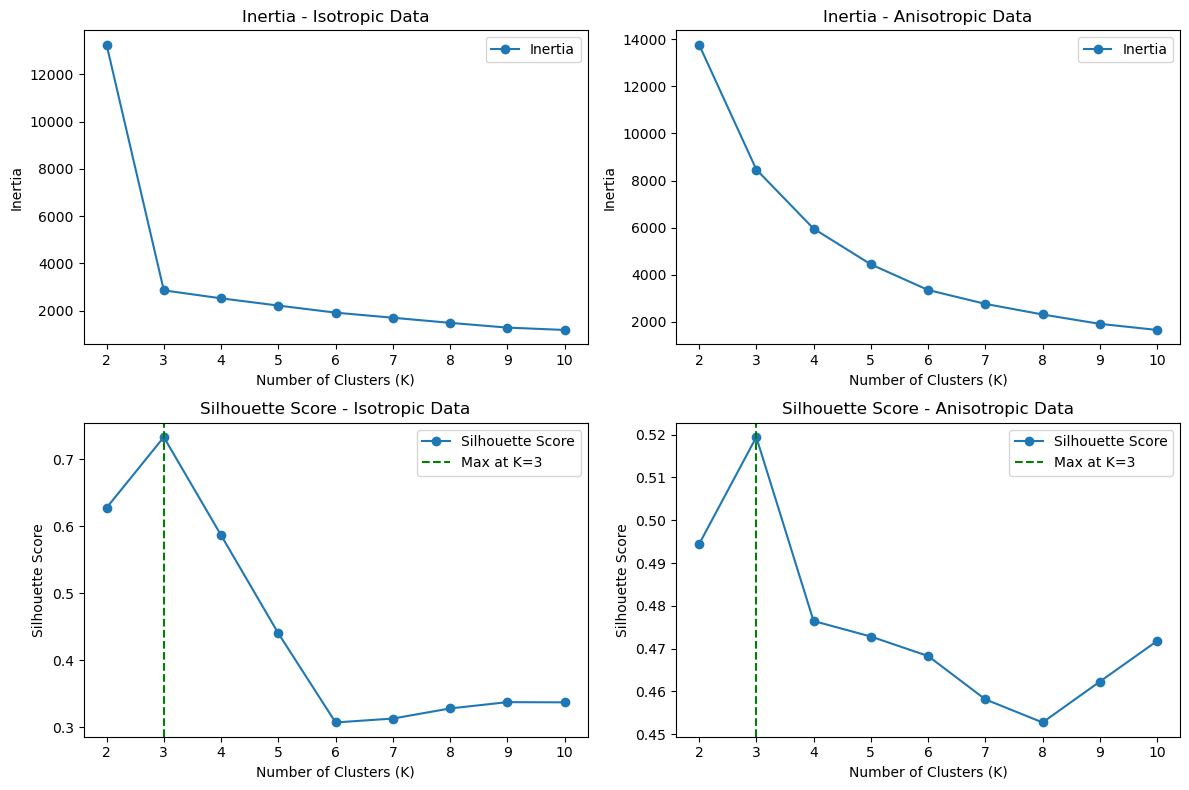

In [565]:
def evaluate_clustering(x, k_range):
    inertia = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(x)
        inertia.append(kmeans.inertia_)
        if k > 1:
            silhouette_scores.append(silhouette_score(x, labels))
        else:
            silhouette_scores.append(np.nan)
    return inertia, silhouette_scores

k_values = range(2, 11)

inertia_iso, silhouette_iso = evaluate_clustering(x, k_values)
inertia_aniso, silhouette_aniso = evaluate_clustering(xani, k_values)


optimal_k_silhouette_iso = k_values[np.argmax(silhouette_iso)]
optimal_k_silhouette_aniso = k_values[np.argmax(silhouette_aniso)]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(k_values, inertia_iso, marker='o', label='Inertia')
axes[0, 0].set_title("Inertia - Isotropic Data")
axes[0, 0].set_xlabel("Number of Clusters (K)")
axes[0, 0].set_ylabel("Inertia")
axes[0, 0].legend()

axes[0, 1].plot(k_values, inertia_aniso, marker='o', label='Inertia')
axes[0, 1].set_title("Inertia - Anisotropic Data")
axes[0, 1].set_xlabel("Number of Clusters (K)")
axes[0, 1].set_ylabel("Inertia")
axes[0, 1].legend()

axes[1, 0].plot(k_values, silhouette_iso, marker='o', label='Silhouette Score')
axes[1, 0].axvline(optimal_k_silhouette_iso, color='g', linestyle='--', label=f'Max at K={optimal_k_silhouette_iso}')
axes[1, 0].set_title("Silhouette Score - Isotropic Data")
axes[1, 0].set_xlabel("Number of Clusters (K)")
axes[1, 0].set_ylabel("Silhouette Score")
axes[1, 0].legend()

axes[1, 1].plot(k_values, silhouette_aniso, marker='o', label='Silhouette Score')
axes[1, 1].axvline(optimal_k_silhouette_aniso, color='g', linestyle='--', label=f'Max at K={optimal_k_silhouette_aniso}')
axes[1, 1].set_title("Silhouette Score - Anisotropic Data")
axes[1, 1].set_xlabel("Number of Clusters (K)")
axes[1, 1].set_ylabel("Silhouette Score")
axes[1, 1].legend()

plt.tight_layout()
plt.show()



In [685]:
def whiten_data(X):
    mean=np.mean(X, axis=0)
    X_c=X - mean
    cov_matrix=np.cov(X_c, rowvar=False)
    eigvals, eigvecs=np.linalg.eigh(cov_matrix)
    X_whitened=X_c@eigvecs@np.diag(1.0/np.sqrt(eigvals))
    return X_whitened

xaniw= whiten_data(xani)

def evaluate_clustering(X, k_range):
    inertia = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
        if k > 1:
            silhouette_scores.append(silhouette_score(X, labels))
        else:
            silhouette_scores.append(np.nan)
    
    return inertia, silhouette_scores

k_values = range(2, 11)


inertia_iso, silhouette_iso = evaluate_clustering(x, k_values)
inertia_aniso, silhouette_aniso = evaluate_clustering(xani, k_values)
inertia_aniso_whitened, silhouette_aniso_whitened = evaluate_clustering(xaniw, k_values)


optimal_k_silhouette_iso = k_values[np.argmax(silhouette_iso)]
optimal_k_silhouette_aniso = k_values[np.argmax(silhouette_aniso)]
optimal_k_silhouette_aniso_whitened = k_values[np.argmax(silhouette_aniso_whitened)]



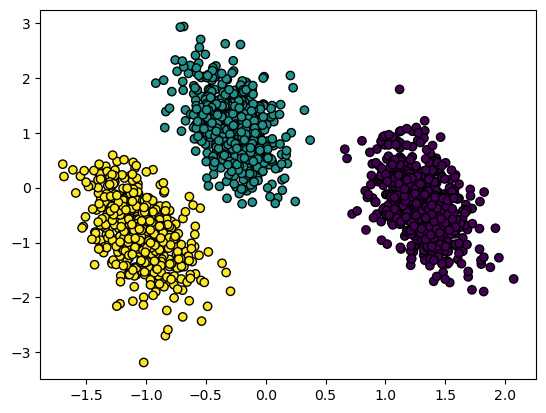

In [687]:
plt.scatter(xaniw[:, 0], xaniw[:, 1], c=y, cmap='viridis', edgecolors='k')

Text(0.5, 1.0, 'K-Means L1 (Anisotropic whitened)')

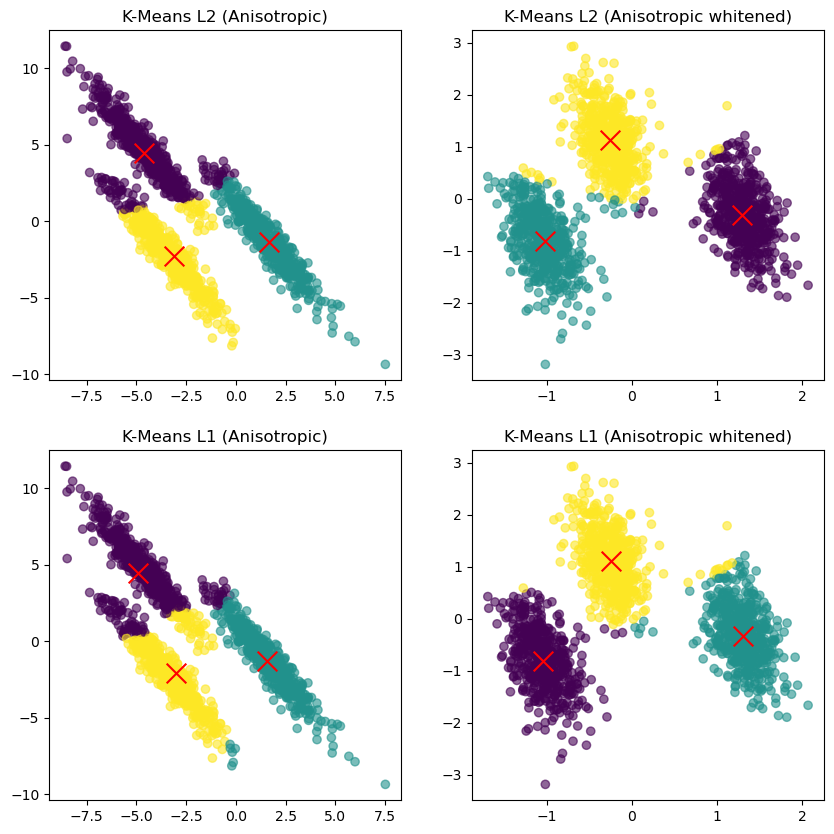

In [705]:
labels_l2_aniw, cents_l2_aniw, _ = kmeans(xaniw, k=3)

labels_l1_aniw, cents_l1_aniw,obj_vals_aniw1= kmeans_l1(xaniw, k=3)
fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].scatter(xani[:, 0], xani[:, 1], c=labels_l2_ani, cmap='viridis', alpha=0.6)
ax[0,0].scatter(cents_l2_ani[:, 0], cents_l2_ani[:, 1], c='red', marker='x', s=200)
ax[0,0].set_title("K-Means L2 (Anisotropic)")

ax[0,1].scatter(xaniw[:, 0], xaniw[:, 1], c=labels_l2_aniw, cmap='viridis', alpha=0.6)
ax[0,1].scatter(cents_l2_aniw[:, 0], cents_l2_aniw[:, 1], c='red', marker='x', s=200)
ax[0,1].set_title("K-Means L2 (Anisotropic whitened)")


ax[1,0].scatter(xani[:, 0], xani[:, 1], c=labels_l1_ani, cmap='viridis', alpha=0.6)
ax[1,0].scatter(cents_l1_ani[:, 0], cents_l1_ani[:, 1], c='red', marker='x', s=200)
ax[1,0].set_title("K-Means L1 (Anisotropic)")

ax[1,1].scatter(xaniw[:, 0], xaniw[:, 1], c=labels_l1_aniw, cmap='viridis', alpha=0.6)
ax[1,1].scatter(cents_l1_aniw[:, 0], cents_l1_aniw[:, 1], c='red', marker='x', s=200)
ax[1,1].set_title("K-Means L1 (Anisotropic whitened)")



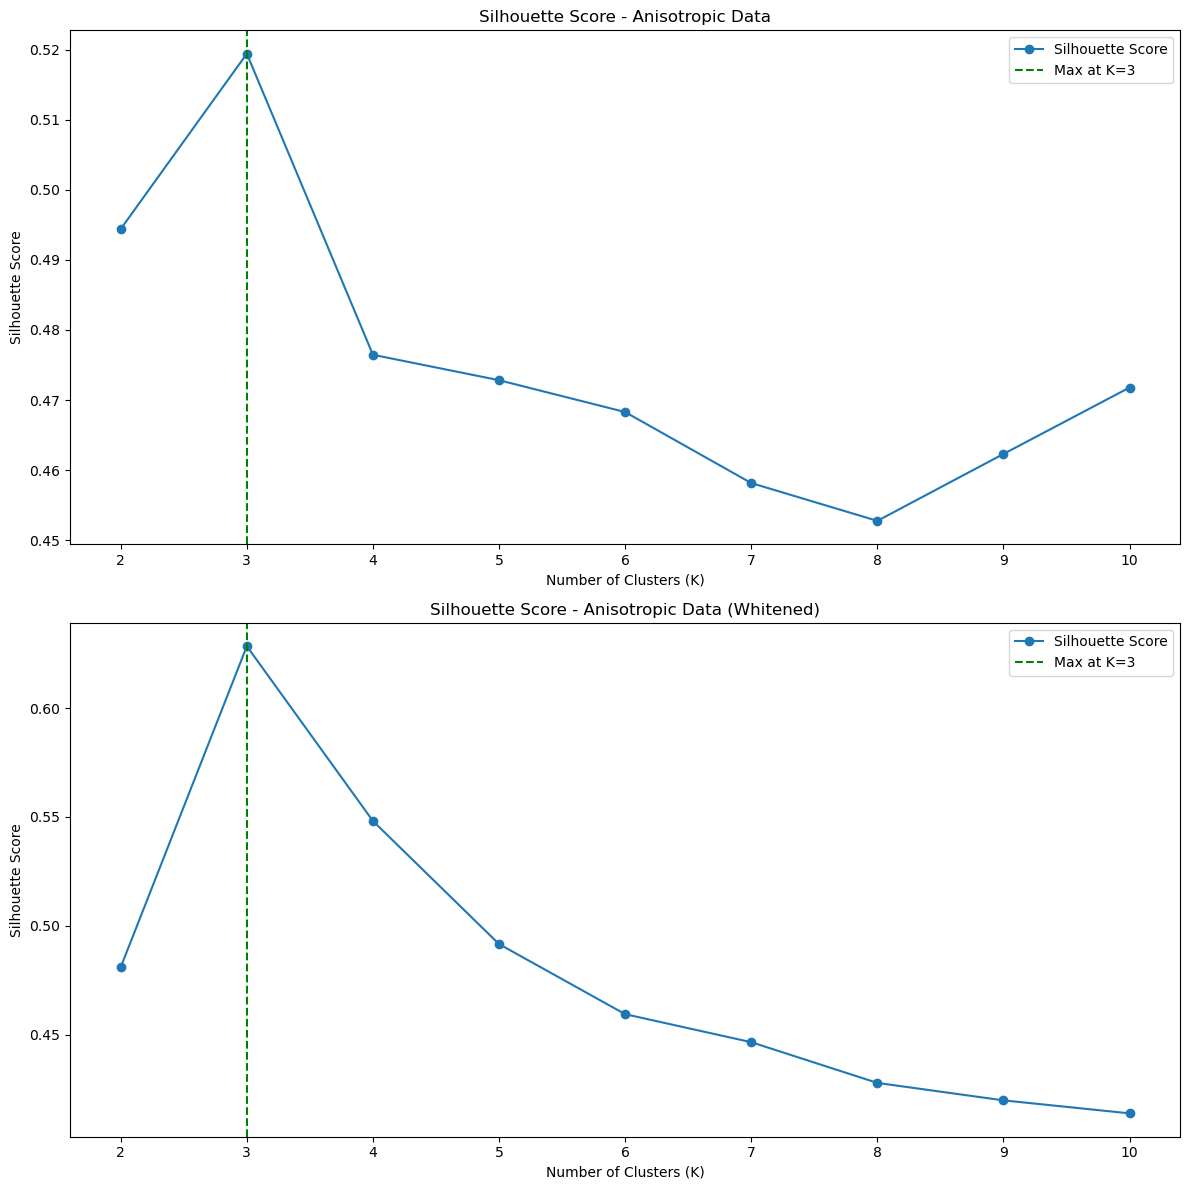

In [693]:

fig, axes = plt.subplots(2,1, figsize=(12, 12))



axes[0].plot(k_values, silhouette_aniso, marker='o', label='Silhouette Score')
axes[0].axvline(optimal_k_silhouette_aniso, color='g', linestyle='--', label=f'Max at K={optimal_k_silhouette_aniso}')
axes[0].set_title("Silhouette Score - Anisotropic Data")
axes[0].set_xlabel("Number of Clusters (K)")
axes[0].set_ylabel("Silhouette Score")
axes[0].legend()

axes[1].plot(k_values, silhouette_aniso_whitened, marker='o', label='Silhouette Score')
axes[1].axvline(optimal_k_silhouette_aniso_whitened, color='g', linestyle='--', label=f'Max at K={optimal_k_silhouette_aniso_whitened}')
axes[1].set_title("Silhouette Score - Anisotropic Data (Whitened)")
axes[1].set_xlabel("Number of Clusters (K)")
axes[1].set_ylabel("Silhouette Score")
axes[1].legend()

plt.tight_layout()
plt.show()

<ipython-input-17-276ffafcd2b7>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


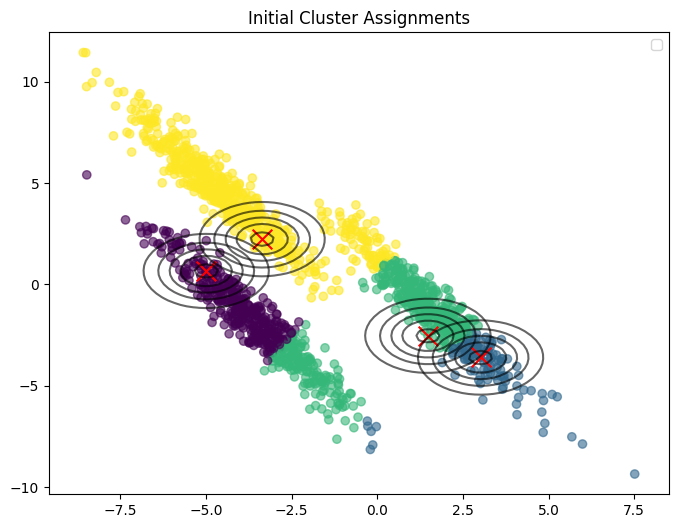

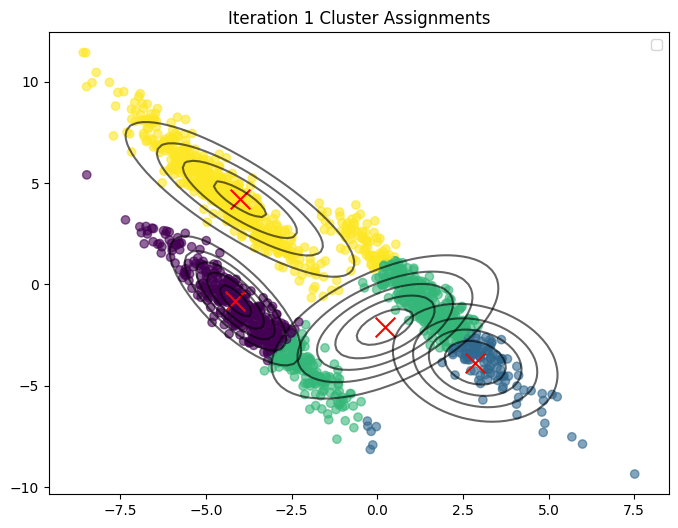

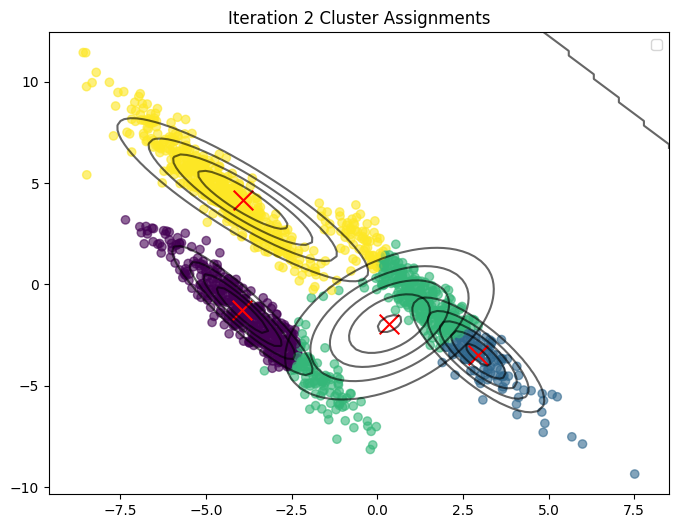

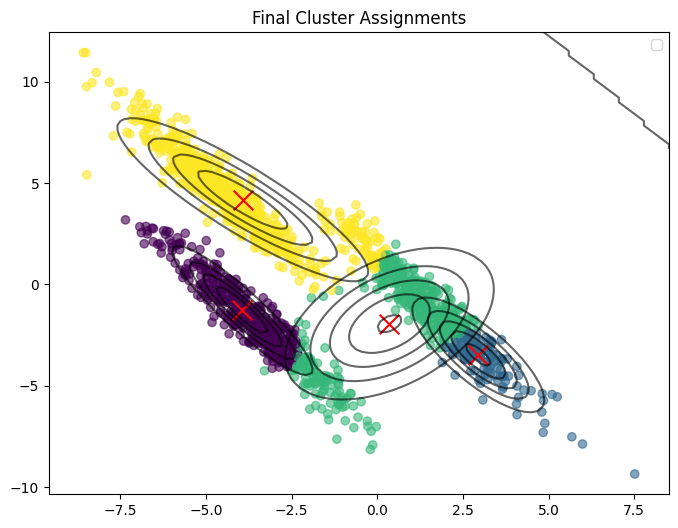

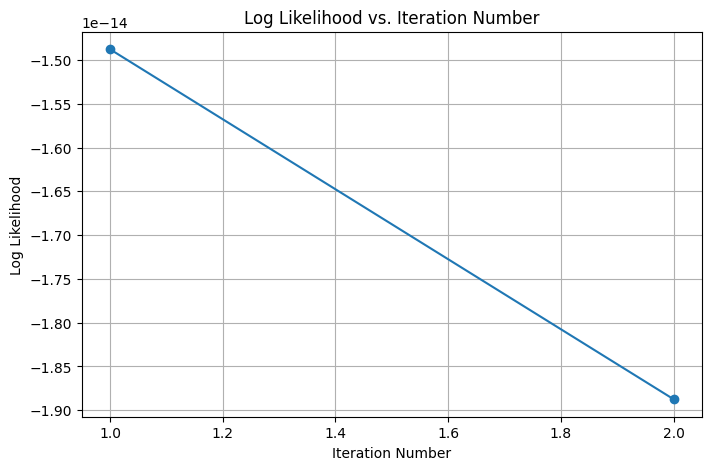

In [17]:
# Problem 2.1

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs
import random

# generate the anisotropic dataset

n_samples = 1500
random_state = 170
transformation = np.array([[1, -1], [-1, 2]])
X, _ = make_blobs(n_samples=n_samples, random_state=random_state)
X_anisotropic = np.dot(X, transformation)

# define gaussian pdf function

def gaussian_pdf(X, mean, cov):
    return multivariate_normal(mean=mean, cov=cov).pdf(X)

# define function to plot clusters with gaussian contours

def plot_clusters(X, means, covariances, gamma, title):
    cluster_assignments = np.argmax(gamma, axis=1)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=cluster_assignments, cmap="viridis", alpha=0.6)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    for k in range(len(means)):
        zz = multivariate_normal(mean=means[k], cov=covariances[k]).pdf(grid_points)
        zz = zz.reshape(xx.shape)
        plt.contour(xx, yy, zz, levels=5, alpha=0.6, colors='black')
    plt.scatter(means[:, 0], means[:, 1], color="red", marker="x", s=200)
    plt.title(title)
    plt.legend()
    plt.show()

# EM alg for GMM

def gmm_em(X, K, max_iter=10, tol=1e-4):
    np.random.seed(42)
    N, D = X.shape

    # initialize parameters

    means = X[np.random.choice(N, K, replace=False)]  # randomly choose K means
    covariances = np.array([np.eye(D) for _ in range(K)])  # identity matrices
    weights = np.ones(K) / K  # uniform mixing coefficients
    log_likelihoods = []

    # initial plot
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])
    gamma /= np.sum(gamma, axis=1, keepdims=True)
    plot_clusters(X, means, covariances, gamma, "Initial Cluster Assignments")
    for iteration in range(max_iter):
        # E-step
        for k in range(K):
            gamma[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])
        gamma /= np.sum(gamma, axis=1, keepdims=True)

        # M-step
        Nk = np.sum(gamma, axis=0)
        weights = Nk / N
        means = np.dot(gamma.T, X) / Nk[:, None]
        for k in range(K):
            diff = X - means[k]
            covariances[k] = np.dot(gamma[:, k] * diff.T, diff) / Nk[k]

        # log-likelihood computation
        log_likelihood = np.sum(np.log(np.sum(gamma, axis=1)))
        log_likelihoods.append(log_likelihood)

        # plot clustering result at each iteration
        plot_clusters(X, means, covariances, gamma, f"Iteration {iteration + 1} Cluster Assignments")

        # check convergence
        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    # plot final clustering result
    plot_clusters(X, means, covariances, gamma, "Final Cluster Assignments")

    # plot log-likelihood vs. iteration
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(log_likelihoods) + 1), log_likelihoods, marker='o', linestyle='-')
    plt.xlabel("Iteration Number")
    plt.ylabel("Log Likelihood")
    plt.title("Log Likelihood vs. Iteration Number")
    plt.grid(True)
    plt.show()

    return means, covariances, weights, gamma

# Run GMM-EM
K = random.randint(2, 5)  # randomly select K between 2 and 5
means, covariances, weights, gamma = gmm_em(X_anisotropic, K)

In [18]:
# Problem 2.2

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs
import random

# Generate the anisotropic dataset
n_samples = 1500
random_state = 170
transformation = np.array([[1, -1], [-1, 2]])
X, _ = make_blobs(n_samples=n_samples, random_state=random_state)
X_anisotropic = np.dot(X, transformation)

# Define Gaussian PDF function
def gaussian_pdf(X, mean, cov):
    return multivariate_normal(mean=mean, cov=cov).pdf(X)

# Define function to plot clusters with Gaussian contours
def plot_clusters(X, means, covariances, gamma, title, covariance_type):
    cluster_assignments = np.argmax(gamma, axis=1)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=cluster_assignments, cmap="viridis", alpha=0.6)

    # Plot Gaussian contours
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    for k in range(len(means)):
        zz = multivariate_normal(mean=means[k], cov=covariances[k]).pdf(grid_points)
        zz = zz.reshape(xx.shape)
        plt.contour(xx, yy, zz, levels=5, alpha=0.6, colors='black')

    plt.scatter(means[:, 0], means[:, 1], color="red", marker="x", s=200)
    plt.title(f"{title} ({covariance_type})")
    plt.legend()
    plt.show()

# EM Algorithm for GMM with Covariance Constraints
def gmm_em(X, K, max_iter=10, tol=1e-4, covariance_type="full"):
    np.random.seed(42)
    N, D = X.shape
    means = X[np.random.choice(N, K, replace=False)]
    covariances = np.array([np.eye(D) for _ in range(K)])  # Identity matrices
    weights = np.ones(K) / K
    log_likelihoods = []

    # Initial plot
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])
    gamma /= np.sum(gamma, axis=1, keepdims=True)
    plot_clusters(X, means, covariances, gamma, "Initial Cluster Assignments", covariance_type)

    for iteration in range(max_iter):
        # E-step
        for k in range(K):
            gamma[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])
        gamma /= np.sum(gamma, axis=1, keepdims=True)

        # M-step
        Nk = np.sum(gamma, axis=0)
        weights = Nk / N
        means = np.dot(gamma.T, X) / Nk[:, None]

        if covariance_type == "full":
            for k in range(K):
                diff = X - means[k]
                covariances[k] = np.dot(gamma[:, k] * diff.T, diff) / Nk[k]
        elif covariance_type == "diag":
            for k in range(K):
                diff = X - means[k]
                cov_matrix = np.dot(gamma[:, k] * diff.T, diff) / Nk[k]
                covariances[k] = np.diag(np.diag(cov_matrix))  # Zero out non-diagonal elements
        elif covariance_type == "tied":
            tied_cov = np.zeros((D, D))
            for k in range(K):
                diff = X - means[k]
                tied_cov += np.dot(gamma[:, k] * diff.T, diff)
            tied_cov /= N
            covariances = np.array([tied_cov] * K)

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum(gamma, axis=1)))
        log_likelihoods.append(log_likelihood)

        # Plot clustering result at each iteration
        plot_clusters(X, means, covariances, gamma, f"Iteration {iteration + 1} Cluster Assignments", covariance_type)

        # Check convergence
        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    # Final clustering result
    plot_clusters(X, means, covariances, gamma, "Final Cluster Assignments", covariance_type)

    return means, covariances, weights, gamma, log_likelihoods

# Randomly select K between 2 and 5
K = random.randint(2, 5)

# Run different GMM Variants with step-by-step visualizations
print(f"Running GMM with K={K} clusters...")

# Full covariance GMM
means_full, cov_full, weights_full, gamma_full, log_likelihoods_full = gmm_em(X_anisotropic, K, covariance_type="full")

# Diagonal covariance GMM
means_diag, cov_diag, weights_diag, gamma_diag, log_likelihoods_diag = gmm_em(X_anisotropic, K, covariance_type="diag")

# Tied covariance GMM
means_tied, cov_tied, weights_tied, gamma_tied, log_likelihoods_tied = gmm_em(X_anisotropic, K, covariance_type="tied")

# Plot log-likelihoods
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(log_likelihoods_full) + 1), log_likelihoods_full, label="Full Covariance", marker='o')
plt.plot(range(1, len(log_likelihoods_diag) + 1), log_likelihoods_diag, label="Diagonal Covariance", marker='s')
plt.plot(range(1, len(log_likelihoods_tied) + 1), log_likelihoods_tied, label="Tied Covariance", marker='d')
plt.xlabel("Iteration Number")
plt.ylabel("Log Likelihood")
plt.title("Log Likelihood vs. Iteration Number for Different Covariance Models")
plt.legend()
plt.grid(True)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

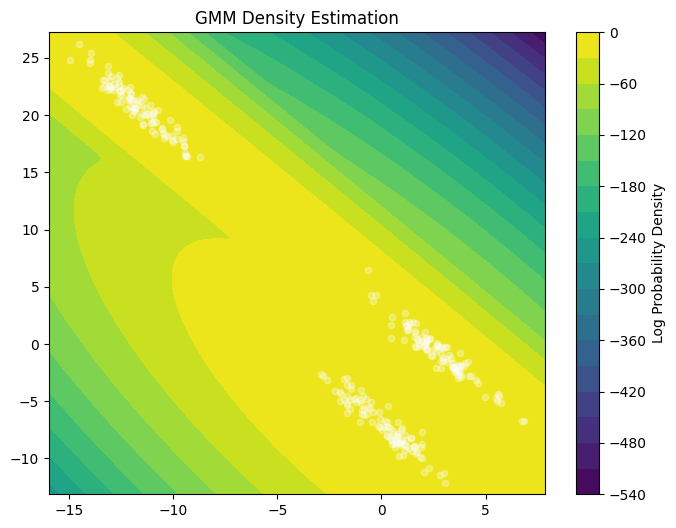

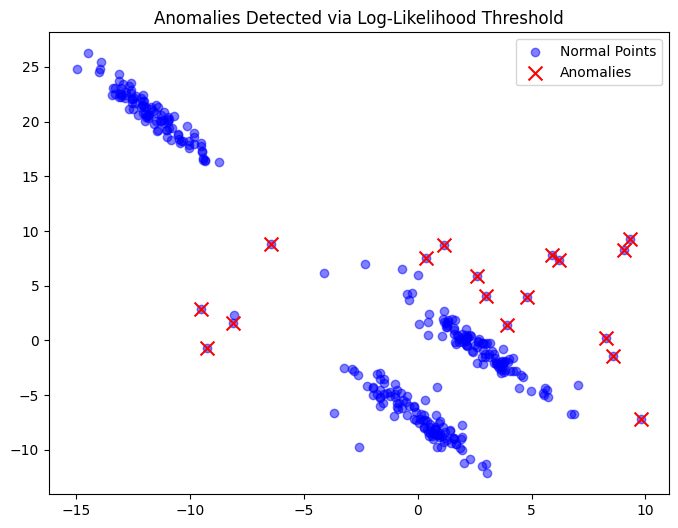

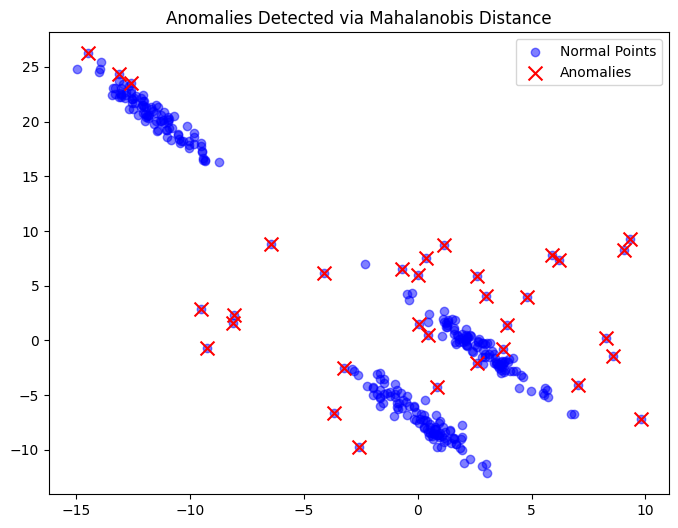

In [21]:
# Problem 2.3

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs
import random

# generate normal data points
X_normal, _ = make_blobs(n_samples=300, centers=3, random_state=42)
X_normal = np.dot(X_normal, transformation)

# generate synthetic anomalies
X_anomalies = np.random.uniform(low=-10, high=10, size=(30, 2))
X_combined = np.vstack([X_normal, X_anomalies])

# define gaussian pdf function
def gaussian_pdf(X, mean, cov):
    return multivariate_normal(mean=mean, cov=cov).pdf(X)

# define function to plot density contours
def plot_density_contours(X, gmm, title="GMM Density Estimation"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    # compute log-likelihood for each grid point
    log_likelihood = np.zeros(grid_points.shape[0])
    for k in range(len(gmm['means'])):
        log_likelihood += gmm['weights'][k] * gaussian_pdf(grid_points, gmm['means'][k], gmm['covariances'][k])
    log_likelihood = np.log(log_likelihood)
    log_likelihood = log_likelihood.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, log_likelihood, levels=20, cmap='viridis')
    plt.colorbar(label="Log Probability Density")
    plt.scatter(X[:, 0], X[:, 1], c='white', alpha=0.3, s=20)
    plt.title(title)
    plt.show()

# EM alg for GMM
def gmm_em(X, K=3, max_iter=10, tol=1e-4):
    np.random.seed(42)
    N, D = X.shape
    means = X[np.random.choice(N, K, replace=False)]
    covariances = np.array([np.eye(D) for _ in range(K)])
    weights = np.ones(K) / K
    log_likelihoods = []
    for iteration in range(max_iter):
        # E-step
        gamma = np.zeros((N, K))
        for k in range(K):
            gamma[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])
        gamma /= np.sum(gamma, axis=1, keepdims=True)
        # M-step
        Nk = np.sum(gamma, axis=0)
        weights = Nk / N
        means = np.dot(gamma.T, X) / Nk[:, None]
        for k in range(K):
            diff = X - means[k]
            covariances[k] = np.dot(gamma[:, k] * diff.T, diff) / Nk[k]
        # compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum(gamma, axis=1)))
        log_likelihoods.append(log_likelihood)
        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    return {"means": means, "covariances": covariances, "weights": weights}

# train GMM on normal data
K = random.randint(2, 5)
gmm_model = gmm_em(X_normal, K)

# plot density estimation
plot_density_contours(X_normal, gmm_model, title="GMM Density Estimation")

# compute log-likelihood scores for anomaly detection
def compute_log_likelihoods(X, gmm):
    log_likelihoods = np.zeros(X.shape[0])
    for k in range(len(gmm['means'])):
        log_likelihoods += gmm['weights'][k] * gaussian_pdf(X, gmm['means'][k], gmm['covariances'][k])
    return np.log(log_likelihoods)

# detect anomalies using log-likelihood threshold
def detect_anomalies_log_likelihood(X, gmm, percentile=5):
    log_likelihoods = compute_log_likelihoods(X, gmm)
    threshold = np.percentile(log_likelihoods, percentile)
    anomalies = log_likelihoods < threshold
    return anomalies

# compute Mahalanobis distance for anomaly detection
def mahalanobis_distance(X, mean, cov):
    cov_inv = np.linalg.inv(cov)
    distances = np.array([np.sqrt((x - mean).T @ cov_inv @ (x - mean)) for x in X])
    return distances
def detect_anomalies_mahalanobis(X, gmm, threshold_percentile=90):
    distances = np.full(X.shape[0], np.inf)  # initialize distances as infinity
    for k in range(len(gmm['means'])):
        # compute Mahalanobis distance from each point to cluster k
        mean = gmm['means'][k]
        cov = gmm['covariances'][k]
        try:
            cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix
        except np.linalg.LinAlgError:
            cov_inv = np.linalg.pinv(cov)  # use pseudo-inverse if not invertible
        dists = np.array([np.sqrt((x - mean).T @ cov_inv @ (x - mean)) for x in X])
        # assign each point to its closest cluster (minimum distance)
        distances = np.minimum(distances, dists)
    # apply thresholding
    threshold = np.percentile(distances, threshold_percentile)
    anomalies = distances > threshold
    return anomalies

# apply anomaly detection methods
log_likelihood_anomalies = detect_anomalies_log_likelihood(X_combined, gmm_model)
mahalanobis_anomalies = detect_anomalies_mahalanobis(X_combined, gmm_model)

# plot detected anomalies
def plot_anomalies(X, anomalies, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label="Normal Points")
    plt.scatter(X[anomalies, 0], X[anomalies, 1], c='red', marker='x', s=100, label="Anomalies")
    plt.title(title)
    plt.legend()
    plt.show()
plot_anomalies(X_combined, log_likelihood_anomalies, "Anomalies Detected via Log-Likelihood Threshold")
plot_anomalies(X_combined, mahalanobis_anomalies, "Anomalies Detected via Mahalanobis Distance")

In [ ]:
'''Q3.1'''

'''Implement both functions using vectorized NumPy operations.
Your implementation should handle input arrays of any shape and be numerically stable.
For the sigmoid function, use techniques to prevent overflow/underflow. For ReLU, in practice, we typically define the gradient at x = 0 as 0 or 1;
 your implementation should document which convention you choose.'''
import numpy as np
class Sigmoid:
  def forward(self, x: np.ndarray) -> np.ndarray:
    """
      Compute the activation function.
      Args:
        x: Input array of any shape
      Returns:
        Array of same shape as input with activation function applied
    """
    #if x >= 0:
    #  return 1 / (1 + np.exp(-x))
    #else:
    #  exp_of_n = np.exp(x)
      # we write the function 1 / (1 + e^x) so that it the overflow / underflow is accounted
    #  return exp_of_n / (1 + exp_of_n)

    # make vectorizede
    return np.where(
      x >= 0,
      1 / (1 + np.exp(-x)),
      np.exp(x) / (1 + np.exp(x))
    )

  def backward(self, x: np.ndarray) -> np.ndarray:
    """
    Compute the gradient of the activation function.
    Args:
      x: Input array of any shape
    Returns:
      Array of same shape as input with gradient computed
    """
    sigmoid_of_x = self.forward(x)
    return sigmoid_of_x * (1 - sigmoid_of_x)


class ReLU:
  def forward(self, x: np.ndarray) -> np.ndarray:
    """
      Compute the activation function.
      Args:
        x: Input array of any shape
      Returns:
        Array of same shape as input with activation function applied
    """
    # if x <=0 return 0, else return x
    return np.maximum(0, x)

  def backward(self, x: np.ndarray) -> np.ndarray:
    """
  Compute the gradient of the activation function.
    Args:
      x: Input array of any shape
    Returns:
      Array of same shape as input with gradient computed
  """
    # in our instance we established the gradient @ x=0 to = 0
    # np where(function, what do if true, what do if false)
    return np.where(x > 0, 1, 0)


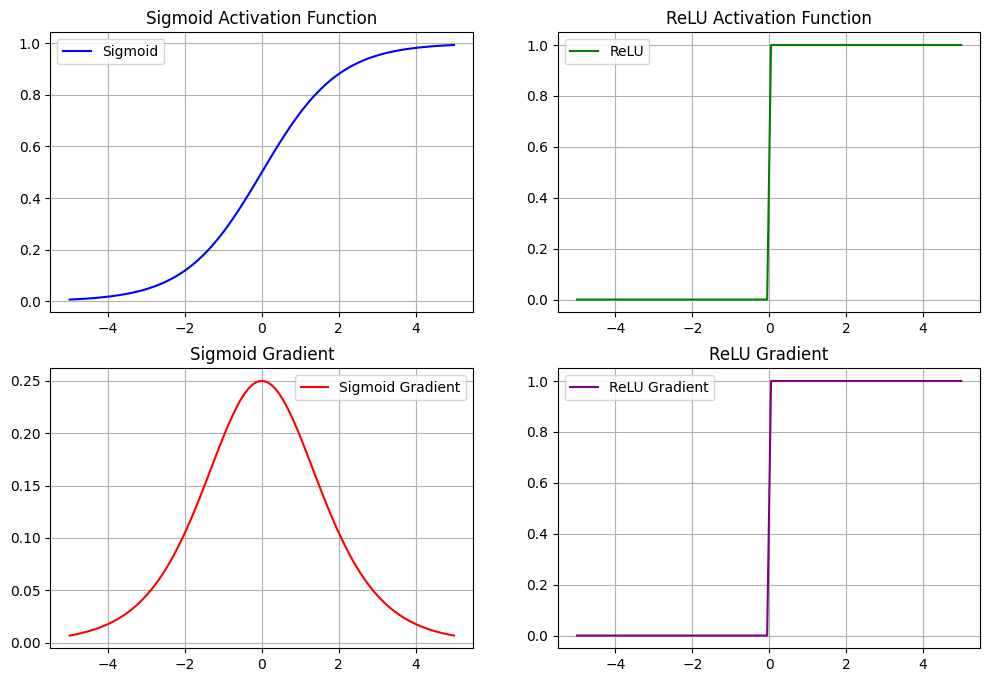

In [ ]:
# 3.1 graphs
import matplotlib.pyplot as plt
x = np.linspace(-5, 5, 100)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))


a_sigmoid = Sigmoid()
a_relu = ReLU()
# Sigmoid Activation Function
axes[0, 0].plot(x, a_sigmoid.forward(x), label='Sigmoid', color='blue')
axes[0, 0].set_title('Sigmoid Activation Function')
axes[0, 0].legend()
axes[0, 0].grid()

# Sigmoid gradient
axes[1, 0].plot(x, a_sigmoid.backward(x), label='Sigmoid Gradient', color='red')
axes[1, 0].set_title('Sigmoid Gradient')
axes[1, 0].legend()
axes[1, 0].grid()

# ReLU Activation function
axes[0, 1].plot(x, a_relu.backward(x), label='ReLU', color='green')
axes[0, 1].set_title('ReLU Activation Function')
axes[0, 1].legend()
axes[0, 1].grid()

# ReLU gradient
axes[1, 1].plot(x, a_relu.backward(x), label='ReLU Gradient', color='purple')
axes[1, 1].set_title('ReLU Gradient')
axes[1, 1].legend()
axes[1, 1].grid()


In [ ]:
# 3.2
import numpy as np
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split


class BinaryCrossEntropyLoss:
  def gradient(self, y_train, out):
    return out - y_train

  def loss(self, y_train, out):
    return (-y_train * np.log(out) - (1 - y_train) * np.log(1 - out)).mean()


class Network:
  def __init__(self, input_size, hidden_size, output_size):

      # define the weights
      self.W1 = np.random.randn(input_size, hidden_size) * 0.01
      self.b1 = np.zeros((1, hidden_size))
      self.W2 = np.random.randn(hidden_size, output_size) * 0.01
      self.b2 = np.zeros((1, output_size))

      # define ReLU and Sigmoid
      self.a_relu = ReLU()
      self.a_sigmoid = Sigmoid()

  def forward(self, x):
    self.X_train = x
    # let's use ReLU since we wrote some ReLU code earlier for the hidden layer
    self.Z1 = x @ self.W1 + self.b1
    self.A1 = self.a_relu.forward(self.Z1)  # Hidden activation
    self.Z2 = self.A1 @ self.W2 + self.b2
    self.A2 = self.a_sigmoid.forward(self.Z2)  # Output activation
    return self.A2

  def forward_test(self, x):

    # this version doesn't save X_train
    self.Z1 = x @ self.W1 + self.b1
    self.A1 = self.a_relu.forward(self.Z1)  # Hidden activation
    self.Z2 = self.A1 @ self.W2 + self.b2
    self.A2 = self.a_sigmoid.forward(self.Z2)  # Output activation
    return self.A2

  def backward(self, grad_loss):
    m = grad_loss.shape[0]

    # Compute gradients for output layer
    dZ2 = grad_loss
    dW2 = (self.A1.T @ dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Compute gradients for hidden layer
    dA1 = dZ2 @ self.W2.T
    dZ1 = dA1 * self.a_relu.backward(self.Z1) #utilizing relu backward
    dW1 = (self.X_train.T @ dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Store gradients for update step
    self.dW1, self.db1 = dW1, db1
    self.dW2, self.db2 = dW2, db2


  def update(self, lr=0.01):
        self.W1 -= lr * self.dW1
        self.b1 -= lr * self.db1
        self.W2 -= lr * self.dW2
        self.b2 -= lr * self.db2

Epoch: 100, Loss: 0.693012197062898, Accuracy: 0.50625
Epoch: 200, Loss: 0.6928674044758172, Accuracy: 0.50625
Epoch: 300, Loss: 0.6924413256514125, Accuracy: 0.50625
Epoch: 400, Loss: 0.6911274347131497, Accuracy: 0.50625
Epoch: 500, Loss: 0.687066750405806, Accuracy: 0.50625
Epoch: 600, Loss: 0.674968975101385, Accuracy: 0.671875
Epoch: 700, Loss: 0.642973088778928, Accuracy: 0.803125
Epoch: 800, Loss: 0.5794524450008346, Accuracy: 0.86875
Epoch: 900, Loss: 0.49498205171418536, Accuracy: 0.903125
Epoch: 1000, Loss: 0.4118443613776533, Accuracy: 0.925


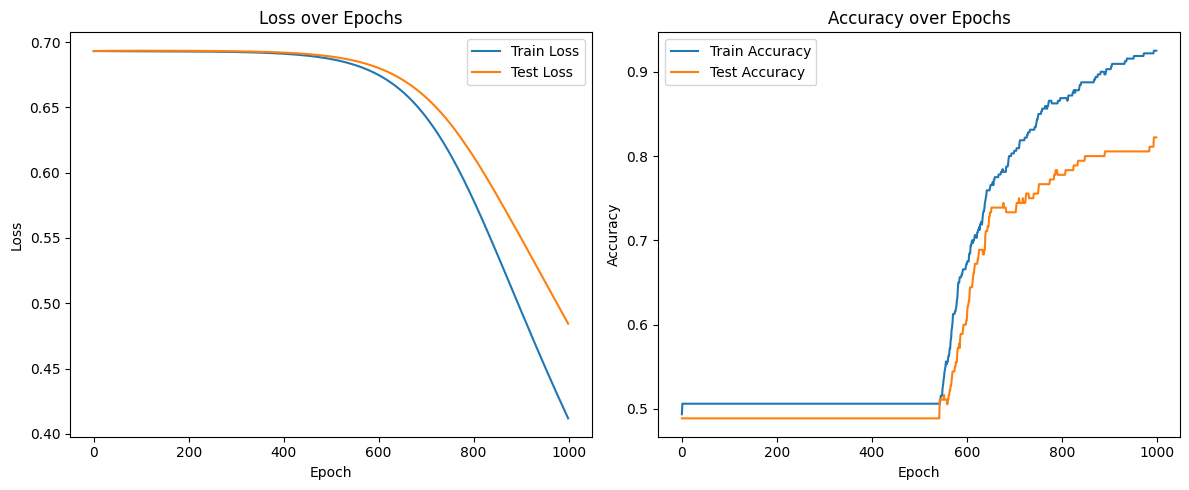


Final Performance:
Training Loss: 0.4118, Training Accuracy: 0.9250
Test Loss: 0.4843, Test Accuracy: 0.8222


In [ ]:
# implement the Network and the Binary Cross Entropy Loss function that was required
# for the given program to run

def load_data():
    X, y = make_circles(noise=0.15, factor=0.3, random_state=1, n_samples=500)
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.36, random_state=42)
    return X_train, X_test, y_train, y_test


criterion = BinaryCrossEntropyLoss()

# (input_size, hidden_size, output_size):
model = Network(input_size=2, hidden_size=8, output_size=1)

X_train, X_test, y_train, y_test = load_data()

# let's add some lists for storing training information to graph later

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, 1001):

    #out = model(X_train) we call the model forward function instead
    out = model.forward(X_train)
    loss_train = criterion.loss(y_train, out)
    grad_loss = criterion.gradient(y_train, out)

    # we compute actual
    acc_train = (np.where(out > 0.5, 1, 0) == y_train).mean()


    model.backward(grad_loss)
    model.update(lr=0.1)

    out_test = model.forward_test(X_test)
    loss_test = criterion.loss(y_test, out_test)
    acc_test = (np.where(out_test > 0.5, 1, 0) == y_test).mean()

    # add everything to array
    train_losses.append(loss_train)
    train_accuracies.append(acc_train)
    test_losses.append(loss_test)
    test_accuracies.append(acc_test)

    # this was 10, changed to 100 to spam the terminal less
    if epoch % 100 == 0:
       loss = criterion.loss(y_train, out)
       acc = (np.where(out > 0.5, 1, 0) == y_train).mean()
       print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {acc}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Report final training and test performance
print("\nFinal Performance:")
print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")


Epoch: 100, Loss: 0.24758404489015823, Accuracy: 0.959375
Epoch: 200, Loss: 0.18563881815789962, Accuracy: 0.978125
Epoch: 300, Loss: 0.15076970993038258, Accuracy: 0.978125
Epoch: 400, Loss: 0.12898709358049826, Accuracy: 0.978125
Epoch: 500, Loss: 0.11421060571642931, Accuracy: 0.975
Epoch: 600, Loss: 0.10342677147291637, Accuracy: 0.975
Epoch: 700, Loss: 0.09517427336046491, Accuracy: 0.975
Epoch: 800, Loss: 0.0886962827645977, Accuracy: 0.975
Epoch: 900, Loss: 0.08356635244755815, Accuracy: 0.975
Epoch: 1000, Loss: 0.07928179260462288, Accuracy: 0.975


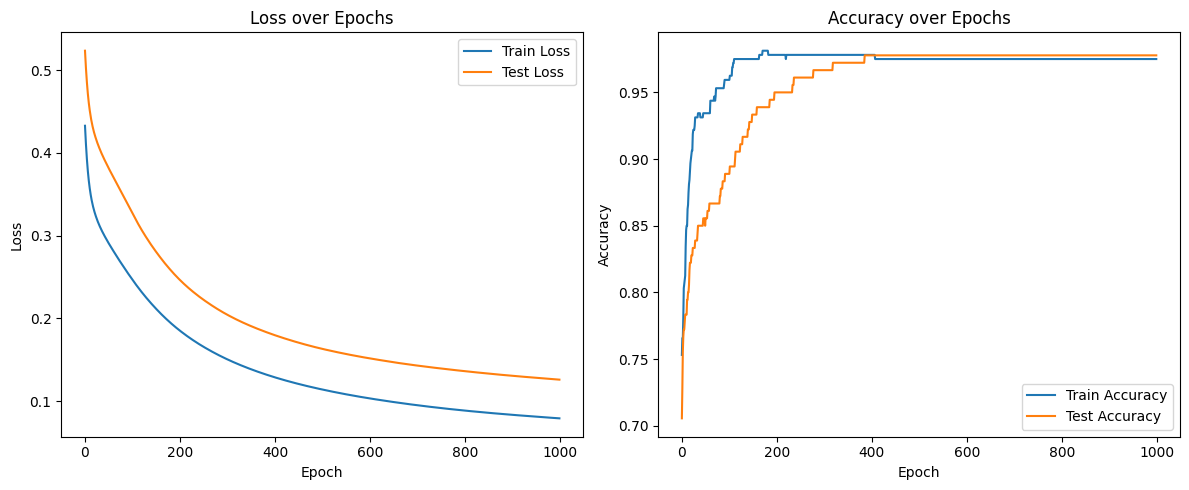


Final Performance:
Training Loss: 0.0793, Training Accuracy: 0.9750
Test Loss: 0.1261, Test Accuracy: 0.9778


In [77]:
# Problem 3.3: Impact of Normalization Schemes

#Train three identical networks that differ only in their normalization scheme: one with no normalization (baseline),
#one with input standardization, and one with batch normalization. Use the same architec- ture, initialization, and hyperparameters across all variants.
#Create a plot comparing training curves (loss and accuracy) for all three variants.
#Report final training and test accuracies. In your report, describe how each normalization scheme affects training convergence and final model performance.
# Note: When implementing input standardization, compute statistics (μ and σ) using only training data to prevent information leakage. Use these same statistics to normalize test data.


# we already trained one without normalization (baseline) from 3.2

# input standardization
from sklearn.preprocessing import StandardScaler


def load_data_input_standardized():
    X, y = make_circles(noise=0.15, factor=0.3, random_state=1, n_samples=500)
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.36, random_state=42)

    # we compute mean, std
    mean = np.mean(X_train)
    std = np.std(X_train)

    X_train = (X_train - mean) / std
    # we use the same features for X_test to prevent inforamtion  leak
    X_test = (X_test - mean) / std

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = load_data_input_standardized()

# let's add some lists for storing training information to graph later

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, 1001):

    #out = model(X_train) we call the model forward function instead
    out = model.forward(X_train)
    loss_train = criterion.loss(y_train, out)
    grad_loss = criterion.gradient(y_train, out)

    # we compute actual
    acc_train = (np.where(out > 0.5, 1, 0) == y_train).mean()


    model.backward(grad_loss)
    model.update(lr=0.1)

    out_test = model.forward_test(X_test)
    loss_test = criterion.loss(y_test, out_test)
    acc_test = (np.where(out_test > 0.5, 1, 0) == y_test).mean()

    # add everything to array
    train_losses.append(loss_train)
    train_accuracies.append(acc_train)
    test_losses.append(loss_test)
    test_accuracies.append(acc_test)

    # this was 10, changed to 100 to spam the terminal less
    if epoch % 100 == 0:
       loss = criterion.loss(y_train, out)
       acc = (np.where(out > 0.5, 1, 0) == y_train).mean()
       print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {acc}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Report final training and test performance
print("\nFinal Performance:")
print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")


Epoch: 100, Loss: 0.07516804183268908, Accuracy: 0.975
Epoch: 200, Loss: 0.07194826708159732, Accuracy: 0.971875
Epoch: 300, Loss: 0.06910555702793025, Accuracy: 0.975
Epoch: 400, Loss: 0.06666536834653157, Accuracy: 0.978125
Epoch: 500, Loss: 0.06454883485389627, Accuracy: 0.98125
Epoch: 600, Loss: 0.062421464103380356, Accuracy: 0.98125
Epoch: 700, Loss: 0.06040272511899388, Accuracy: 0.98125
Epoch: 800, Loss: 0.05878425337536182, Accuracy: 0.98125
Epoch: 900, Loss: 0.05736791560117138, Accuracy: 0.978125
Epoch: 1000, Loss: 0.05610787762100224, Accuracy: 0.978125


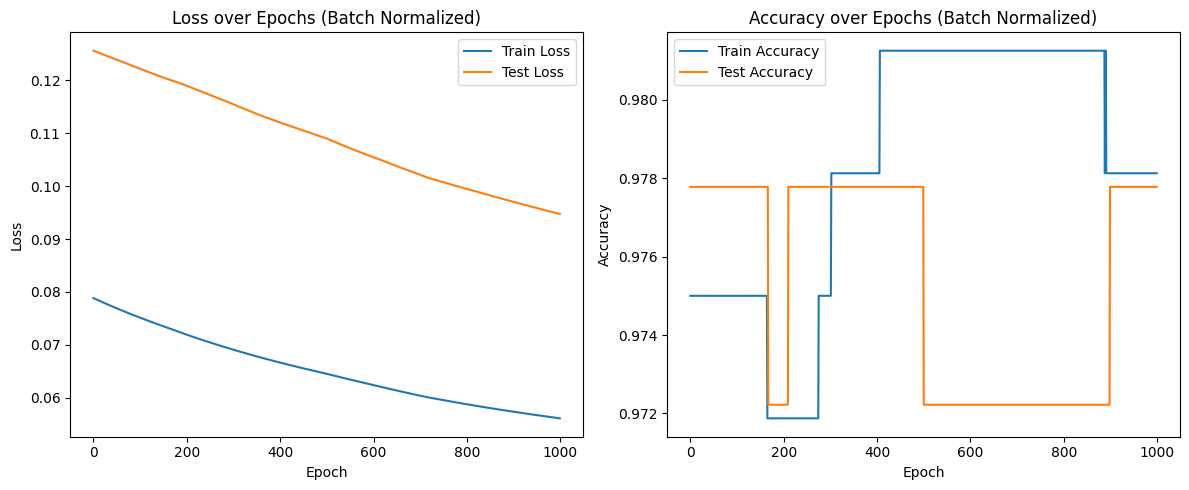


Final Performance:
Training Loss: 0.0561, Training Accuracy: 0.9781
Test Loss: 0.0948, Test Accuracy: 0.9778


In [79]:
# for batch statistics, I'm creating a seperate class with some of the same code
# along with functions to actually perform the batch normalizaiton
def batch_norm_forward(Z, gamma, beta, eps=1e-8):
    # follows h_ = (h - u) / sqrt( sigma^2  + eps)
    # which was given in pset
    mean = np.mean(Z, axis=0, keepdims=True)
    var = np.var(Z, axis=0, keepdims=True)
    Z_norm = (Z - mean) / np.sqrt(var + eps)

    # we shift, y = gamma * h_ + beta
    # which was given in pset
    out = gamma * Z_norm + beta
    cache = (Z, mean, var, Z_norm, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    # calculate the derivatives backward

    Z, mean, var, Z_norm, gamma, beta, eps = cache
    m = Z.shape[0]

    # dgamma and dbeta from chain rule
    dgamma = np.sum(dout * Z_norm, axis=0, keepdims=True)
    dbeta = np.sum(dout, axis=0, keepdims=True)


    #dZ the gamma comes from the derivative
    dZ_norm = dout * gamma
    dvar = np.sum(dZ_norm * (Z - mean) * -0.5 * (var + eps) ** (-3/2), axis=0, keepdims=True)
    dmean = np.sum(dZ_norm * -1 / np.sqrt(var + eps), axis=0, keepdims=True) + dvar * np.mean(-2 * (Z - mean), axis=0, keepdims=True)

    dZ = dZ_norm / np.sqrt(var + eps) + dvar * 2 * (Z - mean) / m + dmean / m
    return dZ, dgamma, dbeta


class NetworkBatchNormalized:
  def __init__(self, input_size, hidden_size, output_size):

      # define the weights
      self.W1 = np.random.randn(input_size, hidden_size) * 0.01
      self.b1 = np.zeros((1, hidden_size))
      self.W2 = np.random.randn(hidden_size, output_size) * 0.01
      self.b2 = np.zeros((1, output_size))

      # define ReLU and Sigmoid
      self.a_relu = ReLU()
      self.a_sigmoid = Sigmoid()

      # for batch statistics we need gamma and beta
      self.gamma = np.ones((1, hidden_size))
      self.beta = np.zeros((1, hidden_size))

  def forward(self, x):
    self.X_train = x
    # let's use ReLU since we wrote some ReLU code earlier for the hidden layer
    self.Z1 = x @ self.W1 + self.b1

    # batch normalize here:
    self.Z1_bn, self.bn_cache = batch_norm_forward(self.Z1, self.gamma, self.beta)

    self.A1 = self.a_relu.forward(self.Z1_bn)  # Hidden activation
    self.Z2 = self.A1 @ self.W2 + self.b2
    self.A2 = self.a_sigmoid.forward(self.Z2)  # Output activation
    return self.A2

  def forward_test(self, x):

    # this version doesn't save X_train
    self.Z1 = x @ self.W1 + self.b1
    self.A1 = self.a_relu.forward(self.Z1)  # Hidden activation
    self.Z2 = self.A1 @ self.W2 + self.b2
    self.A2 = self.a_sigmoid.forward(self.Z2)  # Output activation
    return self.A2

  def backward(self, grad_loss):
    m = grad_loss.shape[0]

    # Compute gradients for output layer
    dZ2 = grad_loss
    dW2 = (self.A1.T @ dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Compute gradients for hidden layer
    dA1 = dZ2 @ self.W2.T
    dZ1_bn = dA1 * self.relu.backward(self.Z1_bn)#utilizing relu backward, but now we add the backward propogation
    dZ1, dgamma, dbeta = batch_norm_backward(dZ1_bn, self.bn_cache)

    dW1 = (self.X_train.T @ dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Store gradients for update step
    self.dW1, self.db1 = dW1, db1
    self.dW2, self.db2 = dW2, db2

    self.dgamma, self.dbeta = dgamma, dbeta



  def update(self, lr=0.01):
    self.W1 -= lr * self.dW1
    self.b1 -= lr * self.db1
    self.W2 -= lr * self.dW2
    self.b2 -= lr * self.db2
    self.gamma -= lr * self.dgamma
    self.beta -= lr * self.dbeta


train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, 1001):

    #out = model(X_train) we call the model forward function instead
    out = model.forward(X_train)
    loss_train = criterion.loss(y_train, out)
    grad_loss = criterion.gradient(y_train, out)

    # we compute actual
    acc_train = (np.where(out > 0.5, 1, 0) == y_train).mean()


    model.backward(grad_loss)
    model.update(lr=0.1)

    out_test = model.forward_test(X_test)
    loss_test = criterion.loss(y_test, out_test)
    acc_test = (np.where(out_test > 0.5, 1, 0) == y_test).mean()

    # add everything to array
    train_losses.append(loss_train)
    train_accuracies.append(acc_train)
    test_losses.append(loss_test)
    test_accuracies.append(acc_test)

    # this was 10, changed to 100 to spam the terminal less
    if epoch % 100 == 0:
       loss = criterion.loss(y_train, out)
       acc = (np.where(out > 0.5, 1, 0) == y_train).mean()
       print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {acc}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs (Batch Normalized)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs (Batch Normalized)")
plt.legend()

plt.tight_layout()
plt.show()

# Report final training and test performance
print("\nFinal Performance:")
print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")


Epoch: 100, Train Loss: 4.2531, Train Accuracy: 0.5316, Test Loss: 4.3954, Test Accuracy: 0.5312
Epoch: 200, Train Loss: 2.0808, Train Accuracy: 0.6691, Test Loss: 2.1098, Test Accuracy: 0.6813
Epoch: 300, Train Loss: 0.7875, Train Accuracy: 0.7906, Test Loss: 0.7685, Test Accuracy: 0.8037
Epoch: 400, Train Loss: 0.3774, Train Accuracy: 0.9469, Test Loss: 0.3552, Test Accuracy: 0.9587
Epoch: 500, Train Loss: 0.2439, Train Accuracy: 0.9844, Test Loss: 0.2249, Test Accuracy: 0.9912
Epoch: 600, Train Loss: 0.1801, Train Accuracy: 0.9956, Test Loss: 0.1640, Test Accuracy: 0.9988
Epoch: 700, Train Loss: 0.1430, Train Accuracy: 0.9978, Test Loss: 0.1291, Test Accuracy: 1.0000
Epoch: 800, Train Loss: 0.1189, Train Accuracy: 0.9981, Test Loss: 0.1066, Test Accuracy: 1.0000
Epoch: 900, Train Loss: 0.1021, Train Accuracy: 0.9988, Test Loss: 0.0910, Test Accuracy: 1.0000
Epoch: 1000, Train Loss: 0.0897, Train Accuracy: 0.9991, Test Loss: 0.0796, Test Accuracy: 1.0000


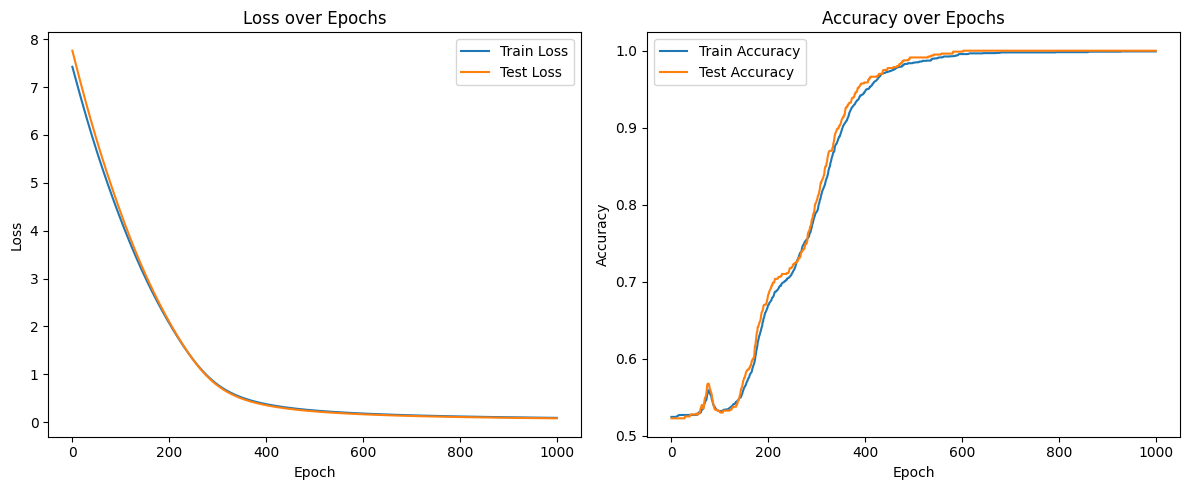


Final Performance:
Training Loss: 0.0897, Training Accuracy: 0.9991
Test Loss: 0.0796, Test Accuracy: 1.0000


In [80]:
# 3.4

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
X, y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=42)
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))  # shape: (1000, 4)
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)


# we're going to make a network class
# instead of modifying the old one, so that we can run all the code seperately

def softmax(z):

    # subtract the max from each row before exponentiating, for stability
    # since we are dealing with a lot of values
    z_shifted = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shifted)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# use instead of ReLU
class LeakyReLU:
    def forward(self, x, alpha=0.01):
        self.alpha = alpha
        return np.where(x > 0, x, alpha * x)

    def backward(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)


class CategoricalCrossEntropy:
    def loss(self, y_true, y_pred):

        # use same eps as before
        eps = 1e-8
        y_pred_clipped = np.clip(y_pred, eps, 1 - eps)
        return -np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))

    def gradient(self, y_true, y_pred):
        batch_size = y_true.shape[0]
        return (y_pred - y_true) / batch_size

class NetworkMultiClass:
  def __init__(self, input_size, hidden_size, output_size):

      # define the weights
      self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
      self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
      self.b1 = np.zeros((1, hidden_size))

      self.b2 = np.zeros((1, output_size))

      # define ReLU and Sigmoid
      self.a_relu = LeakyReLU()
      # don't need sigmoid anymore
      # self.a_sigmoid = Sigmoid()

  def forward(self, x):
    self.X_train = x
    # let's use ReLU since we wrote some ReLU code earlier for the hidden layer
    self.Z1 = x @ self.W1 + self.b1
    self.A1 = self.a_relu.forward(self.Z1)  # Hidden activation
    self.Z2 = self.A1 @ self.W2 + self.b2
    self.A2 = softmax(self.Z2)  # Output activation
    return self.A2

  def forward_test(self, x):

    # this version doesn't save X_train
    self.Z1 = x @ self.W1 + self.b1
    self.A1 = self.a_relu.forward(self.Z1)  # Hidden activation
    self.Z2 = self.A1 @ self.W2 + self.b2
    self.A2 = softmax(self.Z2)  # Output activation
    return self.A2

  def backward(self, grad_loss):
    m = grad_loss.shape[0]

    # Output layer gradients
    dZ2 = grad_loss
    dW2 = (self.A1.T @ dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Hidden layer gradients
    dA1 = dZ2 @ self.W2.T
    dZ1 = dA1 * self.a_relu.backward(self.Z1)
    dW1 = (self.X_train.T @ dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Store gradients
    self.dW1, self.db1 = dW1, db1
    self.dW2, self.db2 = dW2, db2



  def update(self, lr=0.1):
      self.W1 -= lr * self.dW1
      self.b1 -= lr * self.db1
      self.W2 -= lr * self.dW2
      self.b2 -= lr * self.db2

criterion = CategoricalCrossEntropy()
model = NetworkMultiClass(input_size=2, hidden_size=16, output_size=4)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)



for epoch in range(1, 1001):
    # Forward pass (train)
    out = model.forward(X_train)
    loss_train = criterion.loss(y_train, out)
    grad_loss = criterion.gradient(y_train, out)
    acc_train = (np.where(out > 0.5, 1, 0) == y_train).mean()

    model.backward(grad_loss)
    model.update(lr=0.1)

    # Forward pass (test)
    out_test = model.forward_test(X_test)
    loss_test_val = criterion.loss(y_test, out_test)
    acc_test_val = (np.where(out_test > 0.5, 1, 0) == y_test).mean()

    # Record metrics
    train_losses.append(loss_train)
    train_accuracies.append(acc_train)
    test_losses.append(loss_test_val)
    test_accuracies.append(acc_test_val)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, "
              f"Train Loss: {loss_train:.4f}, Train Accuracy: {acc_train:.4f}, "
              f"Test Loss: {loss_test_val:.4f}, Test Accuracy: {acc_test_val:.4f}")

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Final performance
print("\nFinal Performance:")
print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")


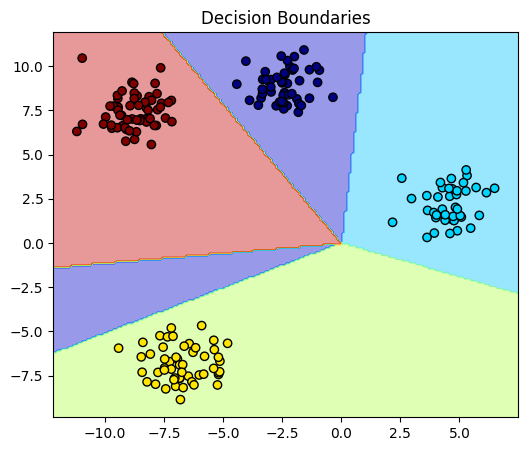

In [81]:

def plot_decision_boundaries(model, X, y_int):
    """
    Plots decision boundaries for a 2D dataset with 4 classes.
    y_int: integer labels for coloring.
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Forward pass on the grid
    probs = model.forward(grid_points)  # shape: (num_points, 4)
    preds = np.argmax(probs, axis=1)    # integer predictions

    zz = preds.reshape(xx.shape)
    plt.contourf(xx, yy, zz, alpha=0.4, cmap=plt.cm.jet)
    plt.scatter(X[:, 0], X[:, 1], c=y_int, edgecolors='k', cmap=plt.cm.jet)
    plt.title("Decision Boundaries")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plt.figure(figsize=(6, 5))
plot_decision_boundaries(model, X_test, y_test_int)
plt.show()


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.02MB/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw


Training autoencoder with latent dimension 2
Epoch [1/20], Train Loss: 0.087459, Test Loss: 0.059091
Epoch [2/20], Train Loss: 0.056233, Test Loss: 0.054381
Epoch [3/20], Train Loss: 0.053271, Test Loss: 0.051945
Epoch [4/20], Train Loss: 0.051406, Test Loss: 0.050072
Epoch [5/20], Train Loss: 0.050094, Test Loss: 0.049033
Epoch [6/20], Train Loss: 0.049233, Test Loss: 0.048595
Epoch [7/20], Train Loss: 0.048688, Test Loss: 0.048228
Epoch [8/20], Train Loss: 0.048253, Test Loss: 0.047790
Epoch [9/20], Train Loss: 0.047862, Test Loss: 0.047365
Epoch [10/20], Train Loss: 0.047590, Test Loss: 0.046931
Epoch [11/20], Train Loss: 0.047343, Test Loss: 0.047012
Epoch [12/20], Train Loss: 0.047097, Test Loss: 0.046542
Epoch [13/20], Train Loss: 0.046882, Test Loss: 0.046566
Epoch [14/20], Train Loss: 0.046629, Test Loss: 0.046369
Epoch [15/20], Train Loss: 0.046441, Test Loss: 0.045998
Epoch [16/20], Train Loss

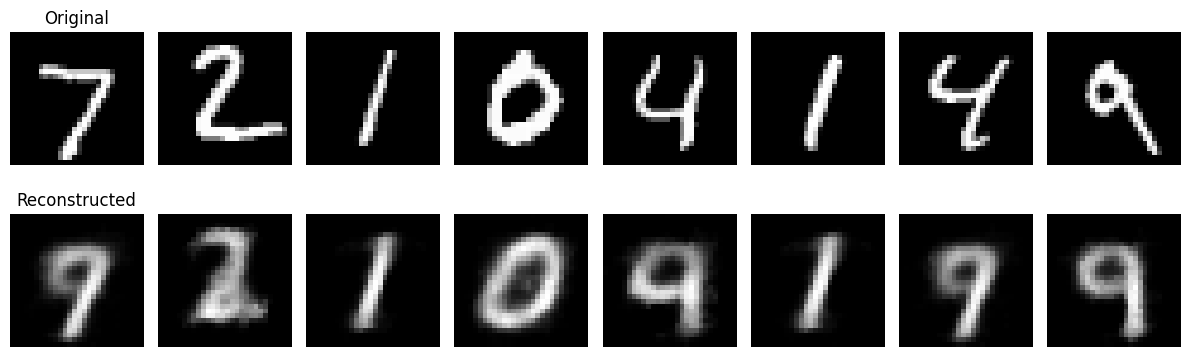

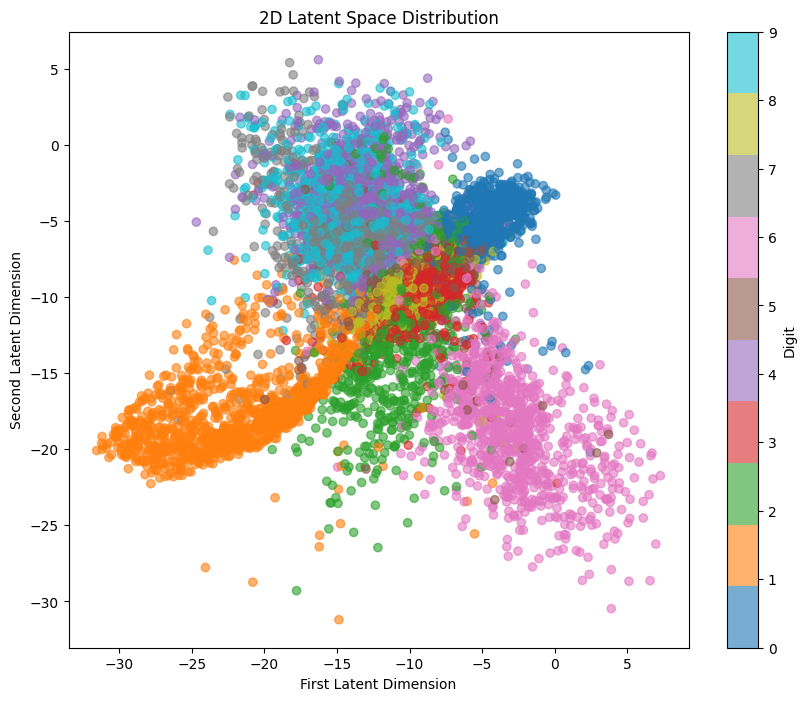

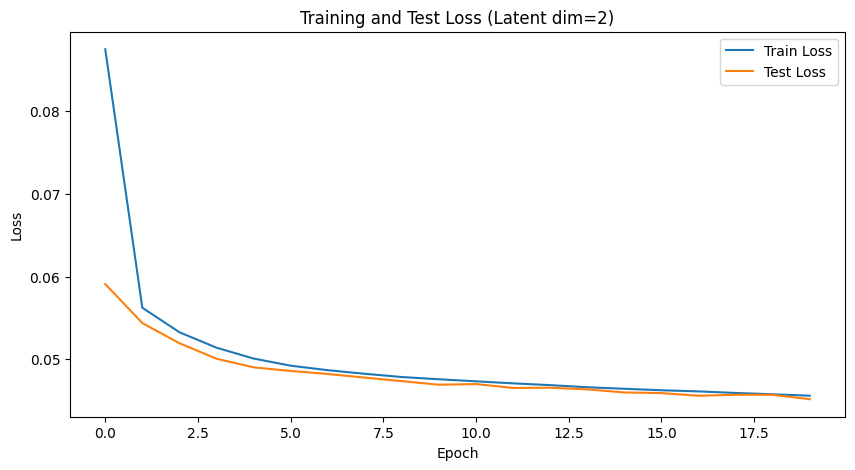


Training autoencoder with latent dimension 8
Epoch [1/20], Train Loss: 0.072088, Test Loss: 0.037891
Epoch [2/20], Train Loss: 0.032525, Test Loss: 0.029401
Epoch [3/20], Train Loss: 0.028636, Test Loss: 0.027374
Epoch [4/20], Train Loss: 0.027148, Test Loss: 0.026217
Epoch [5/20], Train Loss: 0.026134, Test Loss: 0.025289
Epoch [6/20], Train Loss: 0.025419, Test Loss: 0.024633
Epoch [7/20], Train Loss: 0.024817, Test Loss: 0.024631
Epoch [8/20], Train Loss: 0.024342, Test Loss: 0.023682
Epoch [9/20], Train Loss: 0.023939, Test Loss: 0.023272
Epoch [10/20], Train Loss: 0.023578, Test Loss: 0.023278
Epoch [11/20], Train Loss: 0.023291, Test Loss: 0.022731
Epoch [12/20], Train Loss: 0.023042, Test Loss: 0.022577
Epoch [13/20], Train Loss: 0.022793, Test Loss: 0.022278
Epoch [14/20], Train Loss: 0.022600, Test Loss: 0.022143
Epoch [15/20], Train Loss: 0.022448, Test Loss: 0.022067
Epoch [16/20], Train Loss: 0.022251, Test Loss: 0.022136
Epoch [17/20], Train Loss: 0.022124, Test Loss: 0.0

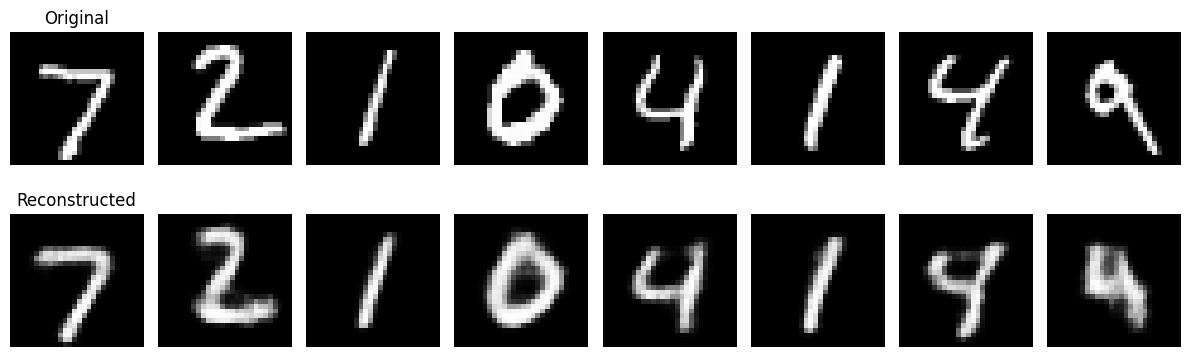

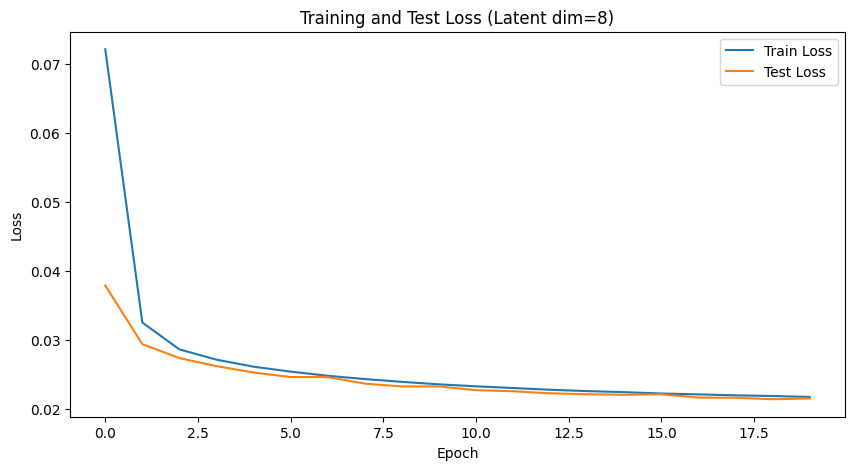


Training autoencoder with latent dimension 16
Epoch [1/20], Train Loss: 0.064585, Test Loss: 0.028483
Epoch [2/20], Train Loss: 0.024143, Test Loss: 0.020850
Epoch [3/20], Train Loss: 0.020335, Test Loss: 0.018994
Epoch [4/20], Train Loss: 0.018833, Test Loss: 0.017806
Epoch [5/20], Train Loss: 0.017896, Test Loss: 0.017080
Epoch [6/20], Train Loss: 0.017172, Test Loss: 0.016449
Epoch [7/20], Train Loss: 0.016581, Test Loss: 0.015857
Epoch [8/20], Train Loss: 0.016076, Test Loss: 0.015327
Epoch [9/20], Train Loss: 0.015598, Test Loss: 0.014889
Epoch [10/20], Train Loss: 0.015163, Test Loss: 0.014515
Epoch [11/20], Train Loss: 0.014775, Test Loss: 0.014203
Epoch [12/20], Train Loss: 0.014421, Test Loss: 0.013961
Epoch [13/20], Train Loss: 0.014113, Test Loss: 0.013526
Epoch [14/20], Train Loss: 0.013838, Test Loss: 0.013346
Epoch [15/20], Train Loss: 0.013575, Test Loss: 0.013159
Epoch [16/20], Train Loss: 0.013386, Test Loss: 0.012909
Epoch [17/20], Train Loss: 0.013171, Test Loss: 0.

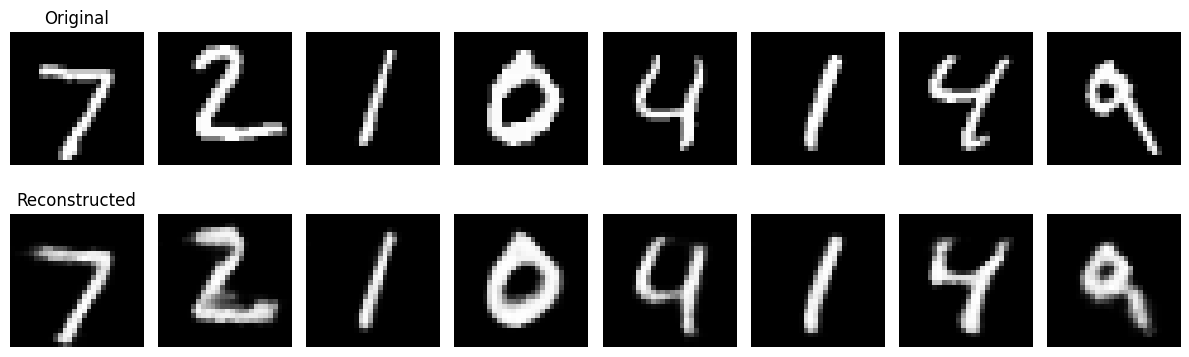

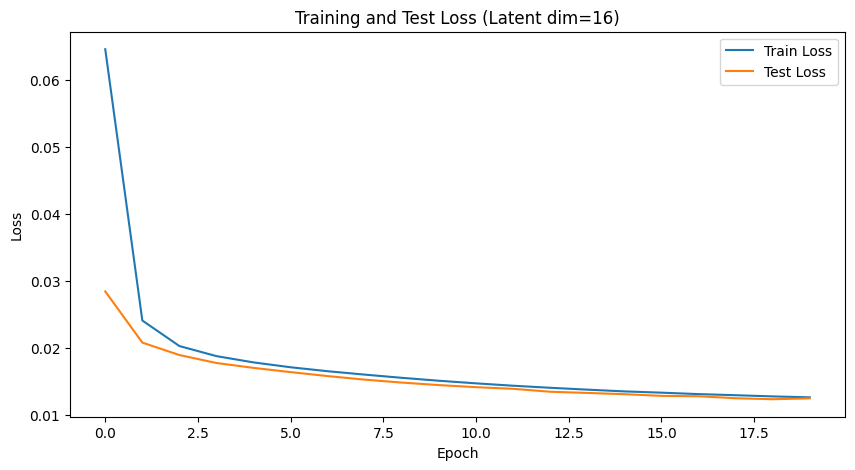


Training autoencoder with latent dimension 32
Epoch [1/20], Train Loss: 0.070720, Test Loss: 0.033409
Epoch [2/20], Train Loss: 0.019268, Test Loss: 0.013561
Epoch [3/20], Train Loss: 0.012167, Test Loss: 0.010354
Epoch [4/20], Train Loss: 0.010132, Test Loss: 0.009396
Epoch [5/20], Train Loss: 0.009068, Test Loss: 0.008410
Epoch [6/20], Train Loss: 0.008482, Test Loss: 0.007859
Epoch [7/20], Train Loss: 0.008054, Test Loss: 0.007532
Epoch [8/20], Train Loss: 0.007774, Test Loss: 0.007312
Epoch [9/20], Train Loss: 0.007513, Test Loss: 0.007103
Epoch [10/20], Train Loss: 0.007337, Test Loss: 0.006938
Epoch [11/20], Train Loss: 0.007154, Test Loss: 0.006773
Epoch [12/20], Train Loss: 0.007001, Test Loss: 0.006634
Epoch [13/20], Train Loss: 0.006899, Test Loss: 0.006747
Epoch [14/20], Train Loss: 0.006765, Test Loss: 0.006467
Epoch [15/20], Train Loss: 0.006677, Test Loss: 0.006304
Epoch [16/20], Train Loss: 0.006585, Test Loss: 0.006257
Epoch [17/20], Train Loss: 0.006516, Test Loss: 0.

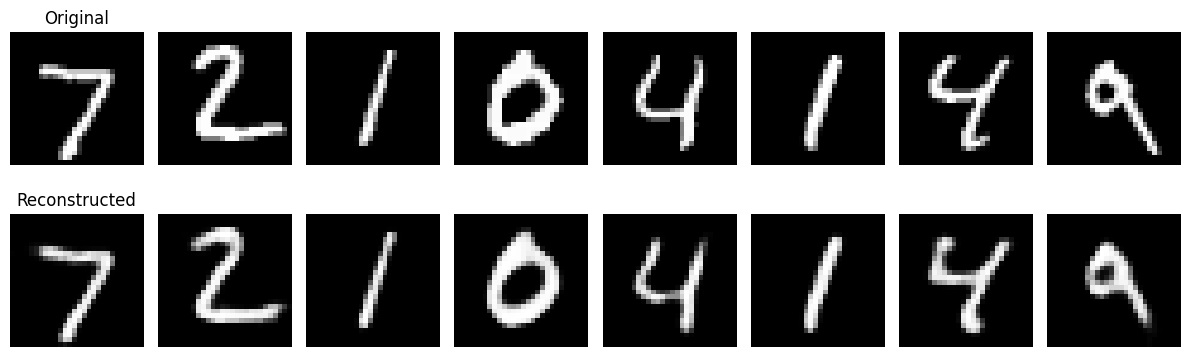

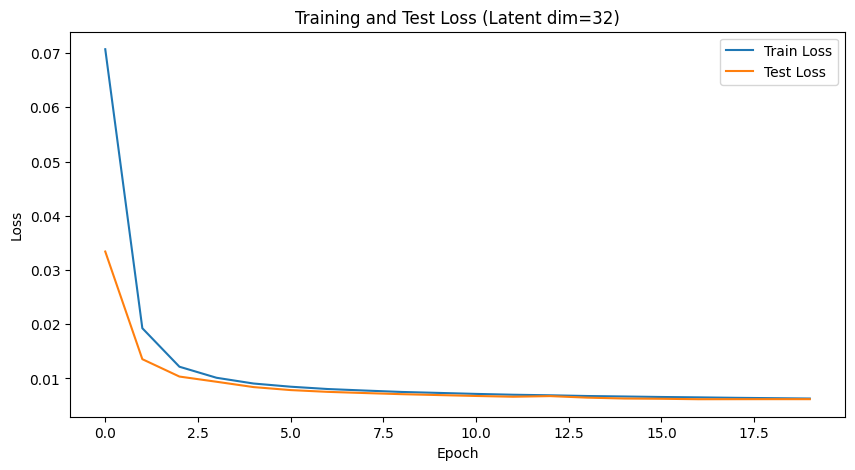

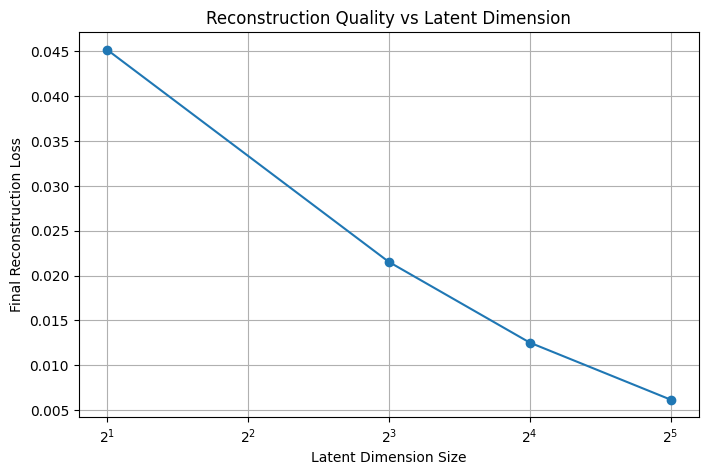

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),   # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8 * 7 * 7, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (8, 7, 7)),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

def train_model(model, num_epochs=20, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            reconstruction, _ = model(data)
            loss = criterion(reconstruction, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                reconstruction, _ = model(data)
                loss = criterion(reconstruction, data)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

    return train_losses, test_losses

def visualize_reconstructions(model, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:8].to(device)  # Take first 8 images
        reconstruction, _ = model(data)

        # Plot original and reconstructed images
        plt.figure(figsize=(12, 4))
        for i in range(8):
            # Original
            plt.subplot(2, 8, i + 1)
            plt.imshow(data[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Original')

            # Reconstruction
            plt.subplot(2, 8, i + 9)
            plt.imshow(reconstruction[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')
        plt.tight_layout()
        plt.show()

def plot_latent_space(model, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    latent_coords = []
    labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            _, latent = model(data)
            latent_coords.append(latent.cpu().numpy())
            labels.append(target.numpy())

    latent_coords = np.concatenate(latent_coords, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_coords[:, 0], latent_coords[:, 1],
                         c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit')
    plt.xlabel('First Latent Dimension')
    plt.ylabel('Second Latent Dimension')
    plt.title('2D Latent Space Distribution')
    plt.show()

# Experiment with different latent dimensions
latent_dims = [2, 8, 16, 32]
reconstruction_losses = []

for dim in latent_dims:
    print(f"\nTraining autoencoder with latent dimension {dim}")
    model = Autoencoder(latent_dim=dim)
    train_losses, test_losses = train_model(model, num_epochs=20)
    reconstruction_losses.append(test_losses[-1])

    # Visualize reconstructions
    visualize_reconstructions(model)

    # For 2D latent space, show the distribution
    if dim == 2:
        plot_latent_space(model)

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Test Loss (Latent dim={dim})')
    plt.legend()
    plt.show()

# Plot reconstruction quality vs latent dimension
plt.figure(figsize=(8, 5))
plt.plot(latent_dims, reconstruction_losses, marker='o')
plt.xscale('log', base=2)
plt.xlabel('Latent Dimension Size')
plt.ylabel('Final Reconstruction Loss')
plt.title('Reconstruction Quality vs Latent Dimension')
plt.grid(True)
plt.show()

In [117]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader, sampler

# Basic transforms
transform = T.Compose([
T.ToTensor(),
T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) ])

# CIFAR-100 for pretraining
cifar100_train = dset.CIFAR100('./data', train=True, download=True, transform=transform)
train_loader_100 = DataLoader(cifar100_train, batch_size=128, shuffle=True, num_workers=4)


# CIFAR-10 with train/val/test split
NUM_TRAIN = 45000
NUM_VAL = 5000

cifar10_train = dset.CIFAR10('./data', train=True, download=True, transform=transform)
cifar10_test = dset.CIFAR10('./data', train=False, download=True, transform=transform)

# Create train/val/test loaders
train_loader = DataLoader(cifar10_train, batch_size=128, sampler=sampler.SubsetRandomSampler(
range(NUM_TRAIN)))
val_loader = DataLoader(cifar10_train, batch_size=128, sampler=sampler.SubsetRandomSampler(
range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))
test_loader = DataLoader(cifar10_test, batch_size=128)

Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(len(train_loader_100))

391


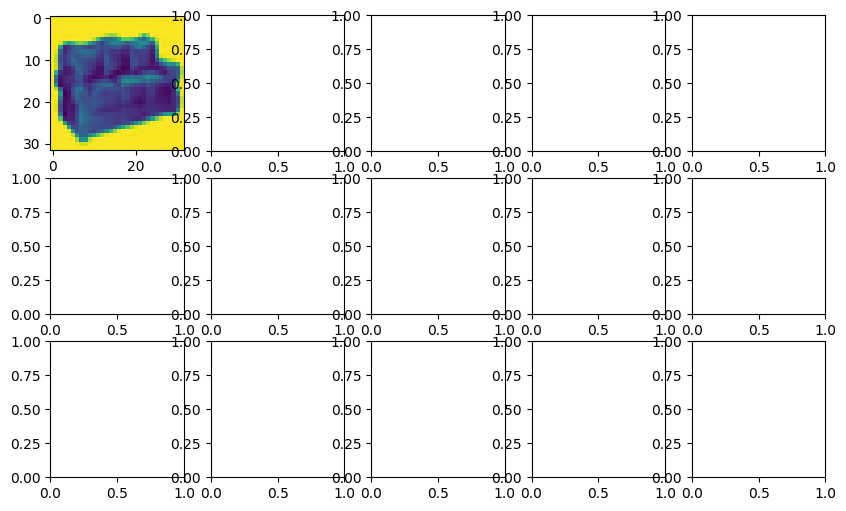

In [2]:
from matplotlib import pyplot as plt
data_iter = iter(train_loader_100)
images, labels = next(data_iter)

# Plot some images
fig, axes = plt.subplots(3, 5, figsize=(10, 6))  # 3 rows, 5 columns
axes = axes.flatten()
axes[0].imshow(images[0][0])
#     img = images[i]  # Show 15 images
#     axes[i].imshow([img[1],img[2]])
#     axes[i].axis('off')

# plt.show()

In [3]:
def add_gaussian_noise(img, mean=0, std=0.1):
    noise = torch.randn_like(img) * std + mean
    return torch.clamp(img + noise, 0, 1)

def add_salt_and_pepper_noise(img, prob=0.1):
    mask = torch.rand_like(img)
    img[mask < (prob / 2)] = 0
    img[mask > 1 - (prob / 2)] = 1
    return img

def add_masking_noise(img, prob=0.1):
    mask = torch.rand_like(img) < prob
    img[mask] = 0
    return img

def add_resolution_noise(image, factor=4):
    x, h, w = image.shape
    small = T.Resize((h // factor, w // factor))(image)
    return T.Resize((h, w))(small)

In [4]:
import torch.nn as nn

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2)
            #nn.Tanh()


        )



    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
loss = nn.MSELoss()
def train(model, dataloader, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    losses = []
    for i in range(epochs):
      iterator = iter(dataloader)

      input, labels = next(iterator)
      x = input.clone()
      #for i in x:
      add_salt_and_pepper_noise(x)
      y = model(x)
      current_loss = loss(y, input)
      losses.append(current_loss.detach().numpy())

      optimizer.zero_grad()
      current_loss.backward()
      optimizer.step()

      print("Losses : " + str(losses[len(losses)  - 1]))







In [6]:
loss = nn.MSELoss()
def train_gaussian_noise(model, dataloader, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    losses = []
    for i in range(epochs):
      iterator = iter(dataloader)

      input, labels = next(iterator)
      x = input.clone()
      for i in x:
        add_gaussian_noise(i)
      y = model(x)
      current_loss = loss(y, input)
      losses.append(current_loss.detach().numpy())

      optimizer.zero_grad()
      current_loss.backward()
      optimizer.step()

      print("Losses : " + str(losses[len(losses)  - 1]))





In [7]:
def train_masking_noise(model, dataloader, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    losses = []
    for i in range(epochs):
      iterator = iter(dataloader)

      input, labels = next(iterator)
      x = input.clone()
      for i in x:
        add_masking_noise(i)
      y = model(x)
      current_loss = loss(y, input)
      losses.append(current_loss.detach().numpy())

      optimizer.zero_grad()
      current_loss.backward()
      optimizer.step()

      print("Losses : " + str(losses[len(losses)  - 1]))

In [8]:
def train_res_noise(model, dataloader, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    losses = []
    for i in range(epochs):
      iterator = iter(dataloader)

      input, labels = next(iterator)
      x = input.clone()
      for i in x:
        add_resolution_noise(i)
      y = model(x)
      current_loss = loss(y, input)
      losses.append(current_loss.detach().numpy())

      optimizer.zero_grad()
      current_loss.backward()
      optimizer.step()

      print("Losses : " + str(losses[len(losses)  - 1]))

In [19]:
model = DenoisingAutoencoder()
train(model, train_loader_100, 1000)


Losses : 1.7338635
Losses : 1.6845261
Losses : 1.6142145
Losses : 1.5276455
Losses : 1.367765
Losses : 1.2278494
Losses : 1.0441799
Losses : 1.0227195
Losses : 0.84913975
Losses : 0.85283524
Losses : 0.7330391
Losses : 0.6899688
Losses : 0.6414747
Losses : 0.550682
Losses : 0.5179095
Losses : 0.47396007
Losses : 0.46755776
Losses : 0.45031974
Losses : 0.46585563
Losses : 0.42613932
Losses : 0.39908335
Losses : 0.4033934
Losses : 0.39693806
Losses : 0.37381122
Losses : 0.37955692
Losses : 0.356298
Losses : 0.36894903
Losses : 0.31307718
Losses : 0.31666443
Losses : 0.32076013
Losses : 0.31749642
Losses : 0.3116499
Losses : 0.2798295
Losses : 0.27492312
Losses : 0.26625046
Losses : 0.27496174
Losses : 0.2678384
Losses : 0.27094346
Losses : 0.28212684
Losses : 0.26248145
Losses : 0.2375617
Losses : 0.25018135
Losses : 0.24469905
Losses : 0.22311322
Losses : 0.24443461
Losses : 0.21954133
Losses : 0.2244926
Losses : 0.21662275
Losses : 0.20251174
Losses : 0.21401596
Losses : 0.2194429
Loss

KeyboardInterrupt: 

In [20]:
train_gaussian_noise(model, train_loader_100, 1000)


Losses : 0.09363225
Losses : 0.24701399
Losses : 0.11425912
Losses : 0.13113335
Losses : 0.15729474
Losses : 0.14639342
Losses : 0.11544827
Losses : 0.09786886
Losses : 0.10728842
Losses : 0.11774945
Losses : 0.12698273
Losses : 0.104577236
Losses : 0.094440676
Losses : 0.09410543
Losses : 0.10305496
Losses : 0.0999932
Losses : 0.09511446
Losses : 0.09442142
Losses : 0.08910812
Losses : 0.08347701
Losses : 0.08463273
Losses : 0.08319651
Losses : 0.08491003
Losses : 0.097408526
Losses : 0.08960137
Losses : 0.07884975
Losses : 0.07879365
Losses : 0.079283476
Losses : 0.08499517
Losses : 0.07941698
Losses : 0.0756081
Losses : 0.08708734
Losses : 0.079210036
Losses : 0.08280671
Losses : 0.08402827
Losses : 0.07721315
Losses : 0.08246588
Losses : 0.08725264
Losses : 0.084125794
Losses : 0.0777656
Losses : 0.08585777
Losses : 0.0772779
Losses : 0.07556633


KeyboardInterrupt: 

In [22]:
train_masking_noise(model, train_loader_100, 1000)


Losses : 0.09529599
Losses : 0.5784953
Losses : 0.13093221
Losses : 0.23159452
Losses : 0.32856473
Losses : 0.25704622
Losses : 0.13748455
Losses : 0.10676902
Losses : 0.15218678
Losses : 0.19452305
Losses : 0.18059929
Losses : 0.15322874
Losses : 0.1251453
Losses : 0.104216926
Losses : 0.119556844
Losses : 0.13520376
Losses : 0.14122452
Losses : 0.12925349
Losses : 0.13170598
Losses : 0.11276317
Losses : 0.10631018
Losses : 0.100859374
Losses : 0.11680011
Losses : 0.11214796
Losses : 0.1158745
Losses : 0.10903093
Losses : 0.10534394
Losses : 0.101752095
Losses : 0.096394874
Losses : 0.10705128
Losses : 0.10415419
Losses : 0.102686726
Losses : 0.10518763
Losses : 0.09695864
Losses : 0.09955177
Losses : 0.100900926
Losses : 0.101557784
Losses : 0.10117424
Losses : 0.09419016
Losses : 0.08620638
Losses : 0.095197804
Losses : 0.09556999
Losses : 0.090163894
Losses : 0.1013821
Losses : 0.08951361
Losses : 0.09419202
Losses : 0.09507755
Losses : 0.09472249
Losses : 0.090654284
Losses : 0.09

KeyboardInterrupt: 

In [23]:
train_res_noise(model, train_loader_100, 1000)


Losses : 0.085869275
Losses : 0.23008871
Losses : 0.13025127
Losses : 0.12186123
Losses : 0.12427459
Losses : 0.15003766
Losses : 0.14068648
Losses : 0.11110286
Losses : 0.09729362
Losses : 0.09945033
Losses : 0.10812249
Losses : 0.112617396
Losses : 0.1206604
Losses : 0.10872033
Losses : 0.08773122
Losses : 0.09202058
Losses : 0.08751879
Losses : 0.09281936
Losses : 0.09247559
Losses : 0.094978236
Losses : 0.08545652
Losses : 0.082237855
Losses : 0.08224376
Losses : 0.08352149
Losses : 0.087909676
Losses : 0.087865986
Losses : 0.08251312
Losses : 0.081789196
Losses : 0.08381655
Losses : 0.08632848
Losses : 0.081592135
Losses : 0.0896092
Losses : 0.081067495
Losses : 0.08518821
Losses : 0.07711939
Losses : 0.072120555
Losses : 0.07672729
Losses : 0.08066846
Losses : 0.07691437
Losses : 0.081782475
Losses : 0.081918605
Losses : 0.08194221
Losses : 0.07161773
Losses : 0.08025419
Losses : 0.07784671
Losses : 0.07639326
Losses : 0.07682022
Losses : 0.078891754
Losses : 0.08085237
Losses : 

KeyboardInterrupt: 

In [9]:
torch.save(model.state_dict(), f'checkpoint_{1}.pth')

NameError: name 'model' is not defined

In [6]:
import numpy as np

fig, axes = plt.subplots(3, 5, figsize=(10, 6))  # 3 rows, 5 columns
axes = axes.flatten()


bruh = iter(train_loader_100)
test_images, labels = next(bruh)
axes[2].imshow(test_images[0][0])
image_noised = add_resolution_noise(test_images[0].clone())
output = model(image_noised)

axes[0].imshow(output[0].detach().numpy())
#axes[1].imshow(np.transpose(images[0], (1, 2, 0)))
axes[1].imshow(image_noised[0])
axes[3].imshow(images[0][1])

print(output)

NameError: name 'plt' is not defined

In [ ]:
print(images[0][0])

tensor([[ 1.6805,  1.7581,  1.7968,  ...,  2.2233,  2.0876,  1.9519],
        [ 0.4787,  1.0602,  1.4867,  ...,  1.6224,  1.3510,  1.1378],
        [-0.6457, -0.4712, -0.1610,  ...,  1.8938,  1.5642,  1.3898],
        ...,
        [-2.2158, -2.2934, -2.2740,  ..., -2.0995, -2.2158, -1.9057],
        [-2.2158, -2.2352, -2.1964,  ..., -2.1189, -2.1964, -1.6924],
        [-2.0414, -2.0995, -2.1383,  ..., -2.1964, -2.0995, -1.5955]])


In [ ]:
print(output[0])

[[9.97118235e-01 9.99619961e-01 9.99983311e-01 ... 9.99940991e-01
  9.99635339e-01 9.97257948e-01]
 [7.51390100e-01 9.90138888e-01 9.98996675e-01 ... 9.99968529e-01
  9.99662995e-01 9.97892559e-01]
 [3.04437848e-03 9.28419270e-03 1.11735195e-01 ... 9.99959230e-01
  9.99839425e-01 9.99400020e-01]
 ...
 [1.44267924e-05 4.09109271e-06 2.18787318e-06 ... 4.38238339e-06
  9.93181675e-06 2.67829691e-05]
 [8.17060281e-05 1.47997580e-05 1.93296023e-06 ... 9.47222998e-06
  8.45529757e-06 6.29132555e-05]
 [1.58017094e-04 2.69346019e-05 5.33069306e-06 ... 1.76375925e-05
  1.20143559e-05 5.89164520e-05]]


In [ ]:
encoder_module = model.encoder
print(encoder_module[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [1]:
conv0 = encoder_module[0]
first_kernel = conv0.weight.data[0]



NameError: name 'encoder_module' is not defined

In [10]:
model = DenoisingAutoencoder()

model.load_state_dict(torch.load('checkpoint_1.pth'))

<ipython-input-10-26c63f8265c4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint_1.pth'))


<All keys matched successfully>

In [37]:
def extract_features(model,dataloader):
  model.eval()
  features = []
  ground_truth = []

  with torch.no_grad():
    for inputs, targets in dataloader:
      output = model.encoder(inputs)
      print(output.shape)
      features.append(output.view(output.size(0), -1))
      ground_truth.append(targets)
  return torch.cat(features, dim = 0), torch.cat(ground_truth, dim = 0)


In [38]:
train_features, train_ground_truth = extract_features(model, train_loader)

torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])
torch.Size([128, 128, 8, 8])


KeyboardInterrupt: 

In [13]:
print(train_ground_truth.shape

      )
print(train_features.shape)

torch.Size([45000])
torch.Size([45000, 8192])


In [14]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(train_features, train_ground_truth)
features_loader = DataLoader(dataset, batch_size=128, shuffle=True)


In [15]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return torch.log_softmax(x, dim=1)

In [29]:
model = DenoisingAutoencoder()

model.load_state_dict(torch.load('checkpoint_1.pth'))

<ipython-input-29-26c63f8265c4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint_1.pth'))


<All keys matched successfully>

In [22]:



def train_classifier(model,loader, epochs):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  if(torch.cuda.is_available()):
    print("GPU Avaialable")
  loss = nn.NLLLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  for i in range(epochs):
    model.train()
    batch_loss = 0
    for batch_feat, batch_labels in loader:
      batch_feat = batch_feat.to(device)
      batch_labels = batch_labels.to(device)
      output = model(batch_feat)
      current_loss = loss(output, batch_labels)
      batch_loss += current_loss.item()

      optimizer.zero_grad()
      current_loss.backward()
      optimizer.step()
    print("Epoch " + str(i) + " Loss: " + str(batch_loss))













In [30]:
print(model)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
  )
)


In [31]:
  classifier = LinearClassifier(8192, 10).to('cuda')


In [32]:
train_classifier(classifier, features_loader, 1000)

GPU Avaialable
Epoch 0 Loss: 638.5256233215332
Epoch 1 Loss: 493.976868391037
Epoch 2 Loss: 461.65656554698944
Epoch 3 Loss: 431.16945481300354
Epoch 4 Loss: 425.1038185954094
Epoch 5 Loss: 398.8302600979805
Epoch 6 Loss: 396.73541301488876
Epoch 7 Loss: 384.1049132347107
Epoch 8 Loss: 370.8080185055733
Epoch 9 Loss: 376.89255142211914
Epoch 10 Loss: 364.80529445409775
Epoch 11 Loss: 362.2598701119423
Epoch 12 Loss: 348.5199617743492
Epoch 13 Loss: 339.89429491758347
Epoch 14 Loss: 332.5569675564766
Epoch 15 Loss: 328.22685730457306
Epoch 16 Loss: 325.9181866645813
Epoch 17 Loss: 324.7782783508301
Epoch 18 Loss: 331.5157399773598
Epoch 19 Loss: 316.9741749763489
Epoch 20 Loss: 309.53368562459946
Epoch 21 Loss: 319.38256496191025
Epoch 22 Loss: 303.4272637963295
Epoch 23 Loss: 295.65094512701035
Epoch 24 Loss: 300.0846776366234
Epoch 25 Loss: 300.5392128229141
Epoch 26 Loss: 297.5741845667362
Epoch 27 Loss: 293.5632607936859
Epoch 28 Loss: 286.57194143533707
Epoch 29 Loss: 282.721991181

In [47]:
def evaluate_accuracy(classifier, loader, device="cuda"):
    model.eval()  # Set to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # No gradients needed for evaluation
        for batch_feat, batch_labels in loader:
            batch_feat = batch_feat.to(device)
            batch_labels = batch_labels.to(device)


            outputs = classifier(batch_feat)
            _, predicted_labels = torch.max(outputs, 1)  # Get predicted class indices

            total_samples += batch_labels.size(0)  # Count total samples
            correct_predictions += (predicted_labels == batch_labels).sum().item()  # Count correct predictions

    accuracy = correct_predictions / total_samples
    return accuracy

In [1]:
test_loader_features, test_loader_ground_truth = extract_features(model.to("cpu"), val_loader)

NameError: name 'extract_features' is not defined

In [64]:
dataset = TensorDataset(test_loader_features, test_loader_ground_truth)
data_loader_test_features = DataLoader(dataset, batch_size=128, shuffle=True)

In [2]:
evaluate_accuracy(classifier, data_loader_val_features)

NameError: name 'evaluate_accuracy' is not defined

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torchvision

In [5]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [96]:
class ResNetSimCLR(nn.Module):
    def __init__(self, base_model, out_dim=128):
        super().__init__()
        self.backbone = base_model
        self.backbone.fc = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        return nn.functional.normalize(z, dim=1)


In [97]:
import numpy as np
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()

        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [85]:
def nt_xent_loss(z, tau=0.5):
    z = F.normalize(z, dim=1)
    N = z.size(0) // 2
    sim = torch.mm(z, z.T) / tau

    mask = torch.eye(2*N, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -float('inf'))


    labels = torch.cat([torch.arange(N, 2*N), torch.arange(N)], dim=0).to(z.device)
    loss = F.cross_entropy(sim, labels)
    return loss

In [120]:
cifar100_train = dset.CIFAR100('./data', train=True, download=True, transform=None)
train_loader_100 = DataLoader(cifar100_train, batch_size=128, shuffle=True, num_workers = 4)

Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [121]:
len(train_loader_100
    )

391

In [122]:
lossfn = SimCLR_Loss(128, 0.5)

In [124]:
model = ResNetSimCLR(torchvision.models.resnet18(pretrained=True)).to('cuda')
for parameter in model.backbone.parameters():
  parameter.requires_grad = False


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
to_pil = torchvision.transforms.ToPILImage()


for epoch in range(50):
    i = 0

    for x, _ in train_loader:
        i += 1



        x1 = torch.stack([train_transform(to_pil(img)) for img in x])
        x2 = torch.stack([train_transform(to_pil(img)) for img in x])
        x = torch.cat([x1, x2], dim=0).to('cuda')


        z = model(x)

        pos_z = z[:len(x1)]
        neg_z = z[len(x1):]
        loss = lossfn(pos_z, neg_z)
        if i % 1 == 0:
          print(i, loss.detach().cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{500}], Loss: {loss.item():.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1 5.4903035
2 5.3503976
3 5.3712764
4 5.2691727
5 5.3160925
6 5.229247
7 5.2187157
8 5.195552
9 5.156014
10 5.1391478
11 5.1863313
12 5.0990267
13 5.091448
14 5.076459
15 5.0909233
16 5.042441
17 5.025112
18 5.0745897
19 4.9949465
20 4.9663906
21 5.077583
22 5.023116
23 5.0713034
24 5.0326285
25 4.974081
26 4.869263
27 4.9151773
28 4.999257
29 4.905964
30 4.9325037
31 4.976387
32 4.998812
33 5.000053
34 4.9735293
35 4.9658737
36 5.0124903
37 4.9037185
38 4.9702516
39 4.947197
40 5.0288963
41 4.9617376
42 4.944277
43 4.919521
44 5.095626
45 4.962767
46 5.016241
47 5.002345
48 4.9189734
49 4.940908
50 4.891432
51 4.9658594
52 5.041246
53 4.850065
54 4.932005
55 4.9462323
56 4.984224
57 4.9014406
58 5.012712
59 4.8113437
60 4.975212
61 4.9320207
62 4.9085217
63 4.9535613
64 5.0428863
65 4.822974
66 4.9830446
67 4.8862567
68 4.922913
69 5.0216913
70 4.8717475
71 4.9389052
72 4.931929
73 4.8891335
74 4.834921
75 4.8960485
76 4.963487
77 4.891577
78 4.878691
79 4.9037585
80 4.9322367
81 4.78

RuntimeError: shape '[256, 1]' is invalid for input of size 32

In [125]:
class classifierSim(nn.Module):
  def __init__(self, pretrained_model, output_dim):
    super().__init__()
    self.pretrained_model = pretrained_model
    self.output_dim = output_dim
    self.classifier = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, self.output_dim)
    )

  def forward(self, x):
    out1 = self.pretrained_model(x)
    return self.classifier(out1)

In [ ]:
simModel = model
for parameter in simModel.parameters():
  parameter.requires_grad = False

final_model = classifierSim(simModel, output_dim=10).to('cuda')

sim_optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(50):
  i = 0
  for x, labels in train_loader:
    i += 1
    x = x.to('cuda')
    labels = labels.to('cuda')
    output = final_model(x)
    loss = loss_fn(output, labels)

    if(i%10):
      print(i, loss)
    sim_optimizer.zero_grad()

    loss.backward()
    sim_optimizer.step()

1 tensor(2.3026, device='cuda:0', grad_fn=<NllLossBackward0>)
2 tensor(2.3002, device='cuda:0', grad_fn=<NllLossBackward0>)
3 tensor(2.3086, device='cuda:0', grad_fn=<NllLossBackward0>)
4 tensor(2.3051, device='cuda:0', grad_fn=<NllLossBackward0>)
5 tensor(2.3050, device='cuda:0', grad_fn=<NllLossBackward0>)
6 tensor(2.2951, device='cuda:0', grad_fn=<NllLossBackward0>)
7 tensor(2.3008, device='cuda:0', grad_fn=<NllLossBackward0>)
8 tensor(2.3050, device='cuda:0', grad_fn=<NllLossBackward0>)
9 tensor(2.2934, device='cuda:0', grad_fn=<NllLossBackward0>)
11 tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>)
12 tensor(2.2947, device='cuda:0', grad_fn=<NllLossBackward0>)
13 tensor(2.2886, device='cuda:0', grad_fn=<NllLossBackward0>)
14 tensor(2.2911, device='cuda:0', grad_fn=<NllLossBackward0>)
15 tensor(2.2830, device='cuda:0', grad_fn=<NllLossBackward0>)
16 tensor(2.2899, device='cuda:0', grad_fn=<NllLossBackward0>)
17 tensor(2.2888, device='cuda:0', grad_fn=<NllLossBackward0>)
1

In [109]:
def evaluate_accuracy_sim(classifier, loader, device="cuda"):
    classifier.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch_feat, batch_labels in loader:
            batch_feat = batch_feat.to(device)
            batch_labels = batch_labels.to(device)


            outputs = classifier(batch_feat)
            _, predicted_labels = torch.max(outputs, 1)

            total_samples += batch_labels.size(0)
            correct_predictions += (predicted_labels == batch_labels).sum().item()

    accuracy = correct_predictions / total_samples
    return accuracy

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms



class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2å
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x




In [34]:
import torch
import random
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

class RotatedCIFAR10(CIFAR10):
    def __init__(self, *args, rotation_angles=[0, 90, 180, 270], **kwargs):
        # Ensure that the dataset does NOT apply any transform initially
        kwargs.pop("transform", None)
        super().__init__(*args, transform=None, **kwargs)

        self.rotation_angles = rotation_angles
        self.to_tensor = T.ToTensor()  # Define ToTensor transformation

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)  # Get image, but now it's a PIL Image
        rotation_idx = random.randint(0, len(self.rotation_angles) - 1)
        angle = self.rotation_angles[rotation_idx]

        # Rotate the PIL image
        rotated_img = TF.rotate(img, angle)

        # Convert to tensor
        rotated_img = self.to_tensor(rotated_img)

        return rotated_img, rotation_idx


In [13]:
import torchvision.datasets as dset
import torchvision.transforms as T


transform = T.Compose([
T.ToTensor(),
T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) ])

cifar100_train = dset.CIFAR100('./data', train=True, download=True, transform=transform)
train_loader_100 = DataLoader(cifar100_train, batch_size=128, shuffle=True)

print(cifar100_train)



Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [35]:
rotated_dataset = RotatedCIFAR10('./data', train=True, download=True, transform=transform)

print(rotated_dataset
      )

Files already downloaded and verified
Dataset RotatedCIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train


In [36]:
rotation_loader = DataLoader(rotated_dataset, batch_size=128, shuffle=True)

In [28]:

pretrained_model = CNN(4)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(pretrained_model.parameters(), lr = 0.001)

In [47]:
epochs = 1000

device = torch.device('cpu')

for i in range(epochs):
  running_loss = 0.0
  batch = next(iter(rotation_loader))
  input, labels = batch
  optimizer.zero_grad()
  outputs = pretrained_model(input)
  current_loss = loss(outputs, labels)
  current_loss.backward()
  optimizer.step()
  running_loss += current_loss.item()
  print(running_loss)


1.0602823495864868
1.1075716018676758
1.003091812133789
1.1116585731506348
1.1913175582885742
1.0829973220825195
1.2212588787078857
1.143858551979065
1.1036672592163086
1.1064605712890625
1.1336427927017212
1.09517502784729
1.0524953603744507
1.128670573234558
1.0524765253067017
1.0133072137832642
1.101358413696289
1.0730987787246704
0.9959226846694946
1.077355146408081
1.3255423307418823
1.015533685684204
1.041581630706787
1.0455420017242432
1.0553011894226074
1.048554539680481
0.9674239754676819
1.0635275840759277
1.1250100135803223
1.0400291681289673
1.0362881422042847
1.0781904458999634
0.9972307085990906
1.0947391986846924
1.0369703769683838
1.028855323791504
1.1768641471862793
0.9872399568557739
1.030256748199463
1.1139981746673584
0.9989571571350098
0.9819113612174988
0.9572886228561401
1.1712027788162231
1.0705581903457642
1.041176199913025
1.1169573068618774
0.951285719871521
1.0902764797210693
1.104816198348999
0.9966902732849121
1.0168176889419556
1.0245407819747925
1.076304

In [50]:
batch = next(iter(rotation_loader))

import matplotlib.pyplot as plt


plt.show(batch[0])

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, rotation_loader, epochs=100, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(rotation_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            x, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if batch_idx % 100 == 99:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {running_loss/100:.3f}, Accuracy: {correct/total:.3f}')
                running_loss = 0.0

        epoch_accuracy = correct / total
        print(f'Epoch {epoch+1} completed - Accuracy: {epoch_accuracy:.3f}')


In [37]:
train_model(pretrained_model, rotation_loader)

Epoch: 1, Batch: 100, Loss: 1.213, Accuracy: 0.484
Epoch: 1, Batch: 200, Loss: 1.031, Accuracy: 0.528
Epoch: 1, Batch: 300, Loss: 0.990, Accuracy: 0.549
Epoch 1 completed - Accuracy: 0.562
Epoch: 2, Batch: 100, Loss: 0.928, Accuracy: 0.622
Epoch: 2, Batch: 200, Loss: 0.910, Accuracy: 0.627
Epoch: 2, Batch: 300, Loss: 0.890, Accuracy: 0.631
Epoch 2 completed - Accuracy: 0.636
Epoch: 3, Batch: 100, Loss: 0.845, Accuracy: 0.654
Epoch: 3, Batch: 200, Loss: 0.832, Accuracy: 0.659
Epoch: 3, Batch: 300, Loss: 0.822, Accuracy: 0.664
Epoch 3 completed - Accuracy: 0.668
Epoch: 4, Batch: 100, Loss: 0.781, Accuracy: 0.687
Epoch: 4, Batch: 200, Loss: 0.780, Accuracy: 0.687
Epoch: 4, Batch: 300, Loss: 0.757, Accuracy: 0.690
Epoch 4 completed - Accuracy: 0.691
Epoch: 5, Batch: 100, Loss: 0.744, Accuracy: 0.704
Epoch: 5, Batch: 200, Loss: 0.734, Accuracy: 0.706
Epoch: 5, Batch: 300, Loss: 0.732, Accuracy: 0.706
Epoch 5 completed - Accuracy: 0.706
Epoch: 6, Batch: 100, Loss: 0.700, Accuracy: 0.722
Epoc

In [38]:
torch.save(pretrained_model.state_dict(), 'pretext_rotation_model.pth')


In [42]:
import torchvision
from torch.utils.data import DataLoader, sampler

# CIFAR-10 with train/val/test split
NUM_TRAIN = 45000
NUM_VAL = 5000

cifar10_train = dset.CIFAR10('./data', train=True, download=True, transform=transform)
cifar10_test = dset.CIFAR10('./data', train=False, download=True, transform=transform)

# Create train/val/test loaders
train_loader = DataLoader(cifar10_train, batch_size=128, sampler=sampler.SubsetRandomSampler(
range(NUM_TRAIN)))
val_loader = DataLoader(cifar10_train, batch_size=128, sampler=sampler.SubsetRandomSampler(
range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))
test_loader = DataLoader(cifar10_test, batch_size=128)


Files already downloaded and verified
Files already downloaded and verified


In [78]:
classfication_model = CNN(10)
classfication_model.features.load_state_dict(pretrained_model.features.state_dict())

<All keys matched successfully>

In [79]:
classfication_model.to("cuda")

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [80]:
for parameter in classfication_model.features.parameters():
  parameter.requires_grad = False


optimizer = torch.optim.Adam(classfication_model.classifier.parameters(),lr = 0.001)
loss_function = nn.CrossEntropyLoss()

classfication_model.train()
for epoch in range(100):
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0
  for inputs, labels in cifar10_loader:
      inputs, labels = inputs.to('cuda'), labels.to('cuda')
      optimizer.zero_grad()
      outputs = classfication_model(inputs)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total_samples += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(cifar10_loader)
  epoch_accuracy = 100.0 * correct_predictions / total_samples
  print(f' Epoch {epoch+1}, Loss: {running_loss/len(cifar10_loader):.4f}',f' Accuracy: {epoch_accuracy}')




 Epoch 1, Loss: 0.9900  Accuracy: 65.956
 Epoch 2, Loss: 0.7179  Accuracy: 75.474
 Epoch 3, Loss: 0.6033  Accuracy: 79.206
 Epoch 4, Loss: 0.4986  Accuracy: 83.032
 Epoch 5, Loss: 0.4049  Accuracy: 86.326
 Epoch 6, Loss: 0.3146  Accuracy: 89.592
 Epoch 7, Loss: 0.2399  Accuracy: 92.572
 Epoch 8, Loss: 0.1783  Accuracy: 94.638
 Epoch 9, Loss: 0.1274  Accuracy: 96.568
 Epoch 10, Loss: 0.0894  Accuracy: 97.868
 Epoch 11, Loss: 0.0630  Accuracy: 98.722
 Epoch 12, Loss: 0.0480  Accuracy: 99.12
 Epoch 13, Loss: 0.0513  Accuracy: 98.742
 Epoch 14, Loss: 0.0434  Accuracy: 98.992
 Epoch 15, Loss: 0.0305  Accuracy: 99.382
 Epoch 16, Loss: 0.0242  Accuracy: 99.552
 Epoch 17, Loss: 0.0385  Accuracy: 98.9
 Epoch 18, Loss: 0.0484  Accuracy: 98.444
 Epoch 19, Loss: 0.0247  Accuracy: 99.332
 Epoch 20, Loss: 0.0222  Accuracy: 99.38
 Epoch 21, Loss: 0.0274  Accuracy: 99.238
 Epoch 22, Loss: 0.0248  Accuracy: 99.304
 Epoch 23, Loss: 0.0344  Accuracy: 98.934
 Epoch 24, Loss: 0.0207  Accuracy: 99.404
 Epoc

In [81]:

def evaluate_model(model, val_loader):
    device = torch.device('cuda')
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            x, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(correct)
    print(total)
    accuracy = 100 * correct / total
    return accuracy

accuracy = evaluate_model(classfication_model, val_loader)
accuracy_test = evaluate_model(classfication_model, test_loader)

4993
5000
7190
10000


In [82]:
print(accuracy)

99.86


In [83]:
print(accuracy_test)

71.9


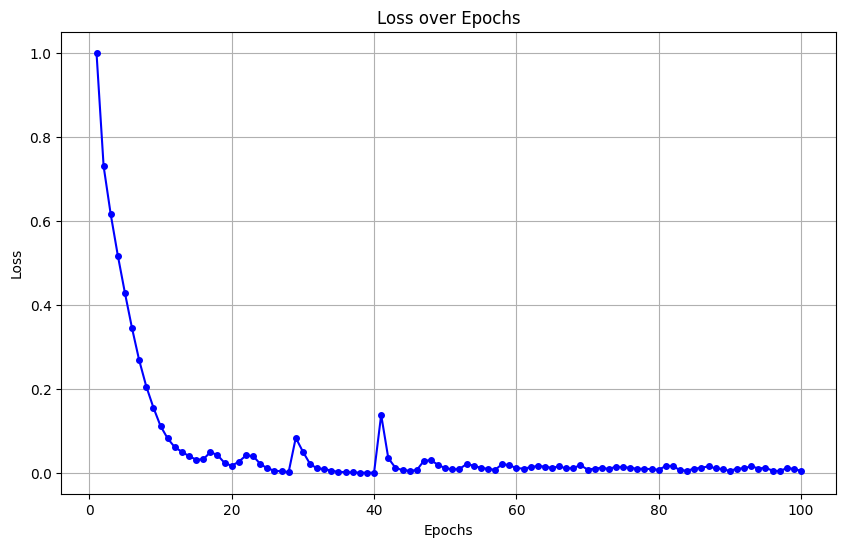

In [69]:
import matplotlib.pyplot as plt

# Loss values from the provided epochs
loss_values = [
    0.9996, 0.7295, 0.6150, 0.5168, 0.4277, 0.3437, 0.2679, 0.2054, 0.1553, 0.1115,
    0.0820, 0.0611, 0.0503, 0.0399, 0.0317, 0.0324, 0.0495, 0.0426, 0.0236, 0.0170,
    0.0268, 0.0415, 0.0403, 0.0217, 0.0108, 0.0056, 0.0035, 0.0022, 0.0835, 0.0506,
    0.0216, 0.0106, 0.0094, 0.0055, 0.0024, 0.0020, 0.0011, 0.0007, 0.0005, 0.0005,
    0.1381, 0.0353, 0.0123, 0.0065, 0.0054, 0.0065, 0.0289, 0.0303, 0.0190, 0.0115,
    0.0082, 0.0096, 0.0210, 0.0174, 0.0120, 0.0098, 0.0074, 0.0209, 0.0186, 0.0114,
    0.0104, 0.0134, 0.0167, 0.0150, 0.0121, 0.0156, 0.0108, 0.0118, 0.0185, 0.0081,
    0.0101, 0.0125, 0.0093, 0.0151, 0.0133, 0.0127, 0.0095, 0.0101, 0.0088, 0.0076,
    0.0166, 0.0166, 0.0063, 0.0056, 0.0102, 0.0123, 0.0157, 0.0108, 0.0092, 0.0046,
    0.0105, 0.0107, 0.0162, 0.0105, 0.0124, 0.0053, 0.0043, 0.0117, 0.0095, 0.0050
]

# Epochs
epochs = list(range(1, 101))

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', color='b', linestyle='-', markersize=4)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
